In [1]:
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
!pip install pyreadstat

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 38.7 MB/s eta 0:00:00


In [2]:
from sklearn.model_selection import GroupKFold
import lightgbm as lgb
import xgboost as xgb
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import RocCurveDisplay

In [3]:
def preprocess(df):
    df.Tx = df.Tx.apply(lambda x: 0 if x=='0:C' else 1).values.tolist()

In [4]:
column_names = ['StuID', 'Gender', 'Tier', 'SchlID', 'TeachID', 'LEP',
       'SpEd', 'Tx', 'Cohort', 'Keep', 'Age1b', 'Tier2_N', 'grp_rate',
       'rcmistot', 'gnrl_fid', 'TKPctCrct', 'Tier2MinRd', 'TYearsTeaching',
       'Time', 't', 'NWFcls', 'NWFwrc', 'ORFwc', 'SAwrS', 'SAsrS', 'SAtoS',
       'RMwidRS', 'RMwdaRS']
df = pd.read_spss("/kaggle/input/student-performance/Ms_Study12Tier12.sav", usecols=column_names)

data = df.dropna()
data_t0 = data[data['t']==0]
data_t1 = data[data['t']==1]

preprocess(data_t0)
preprocess(data_t1)

data_merged = data_t0.merge(data_t1, how = 'inner', on='StuID')

In [5]:
data_ctrl = data_merged[data_merged["Tx_x"]==0]
data_intn = data_merged[data_merged["Tx_x"]==1]

RMwidRS_ref = np.mean(data_ctrl.iloc[:, 53]-data_ctrl.iloc[:, 26])
RMwdaRS_ref = np.mean(data_ctrl.iloc[:, 54]-data_ctrl.iloc[:, 27])



data_merged["RMwidRS_target"] = (data_merged.RMwidRS_y-data_merged.RMwidRS_x).apply(lambda x: 0 if x-RMwidRS_ref<0 else 1)
data_merged["RMwdaRS_target"] = (data_merged.RMwdaRS_y-data_merged.RMwdaRS_x).apply(lambda x: 0 if x-RMwdaRS_ref<0 else 1)

data_ctrl["RMwidRS_target"] = (data_ctrl.RMwidRS_y-data_ctrl.RMwidRS_x).apply(lambda x: 0 if x-RMwidRS_ref<0 else 1)
data_ctrl["RMwdaRS_target"] = (data_ctrl.RMwdaRS_y-data_ctrl.RMwdaRS_x).apply(lambda x: 0 if x-RMwdaRS_ref<0 else 1)

data_intn["RMwidRS_target"] = (data_intn.RMwidRS_y-data_intn.RMwidRS_x).apply(lambda x: 0 if x-RMwidRS_ref<0 else 1)
data_intn["RMwdaRS_target"] = (data_intn.RMwdaRS_y-data_intn.RMwdaRS_x).apply(lambda x: 0 if x-RMwdaRS_ref<0 else 1)

In [6]:
feature_columns = ['Gender_x', 'Tx_x', 'Age1b_x',  'Tier2_N_x', 'grp_rate_x',
                   'rcmistot_x', 'gnrl_fid_x', 'TKPctCrct_x', 'NWFcls_x', 
                   'NWFwrc_x', 'ORFwc_x', 'SAwrS_x', 'SAsrS_x', 'SAtoS_x',
                   'RMwidRS_x', 'RMwdaRS_x']
feature_columns_noTx = ['Gender_x', 'Age1b_x',  'Tier2_N_x', 'grp_rate_x',
                   'rcmistot_x', 'gnrl_fid_x', 'TKPctCrct_x', 'NWFcls_x', 
                   'NWFwrc_x', 'ORFwc_x', 'SAwrS_x', 'SAsrS_x', 'SAtoS_x',
                   'RMwidRS_x', 'RMwdaRS_x']

selected_features_wid = ["Tier2_N_x", "TKPctCrct_x", "NWFwrc_x",  'SAsrS_x', 'SAtoS_x', 'RMwidRS_x', 'RMwdaRS_x']

selected_features_wda = ["Tx_x", "NWFwrc_x", "ORFwc_x", "SAwrS_x", "SAtoS_x", "RMwdaRS_x"]

target_columns = ["RMwidRS_target", "RMwdaRS_target"]
split_coumns= ["StuID", "SchlID"]

# LightGBM

In [7]:
# params = {
#     'boost_from_average':'false',
#     'boost': 'gbdt',
#     'feature_fraction': 1,
#     'learning_rate': 0.05,
#     'max_depth': -1,
#     'metric':'binary_logloss',
#     'num_leaves': 4,
#     'num_threads': 8,
#     'tree_learner': 'serial',
#     'objective': 'binary',
#     'reg_alpha': 2,
#     'reg_lambda': 0,
#     'verbosity': 1,
#     'max_bin':256,
# }

params = {'objective': 'binary',
          'num_leaves': 32,
          'min_data_in_leaf': 32,
          'max_depth': 32,
          'max_bin':256,
          'learning_rate': 0.01,
          'boosting': 'gbdt',
          'feature_fraction': 0.9,
          'bagging_freq': 2,
          'bagging_fraction': 0.8,
          'bagging_seed': 630,
          'metric': 'binary_logloss',
          'verbosity': -1,
          'reg_alpha': 0.15,
          'reg_lambda': 0.36,
          'random_state': 630,
         }

### All features

fold 0 training, target :RMwidRS_target
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[1000]	training's binary_error: 0.0575139	training's binary_logloss: 0.305264	valid_1's binary_error: 0.330882	valid_1's binary_logloss: 0.587946
[2000]	training's binary_error: 0.00556586	training's binary_logloss: 0.180041	valid_1's binary_error: 0.323529	vali

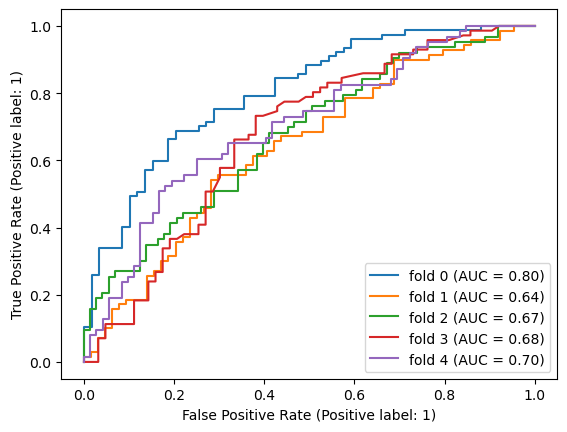

accuracy:0.6651154358924333, specificity: 0.6343330900969628, sensitivity:0.6961758429364063, balanced_score: 0.6652544665166845


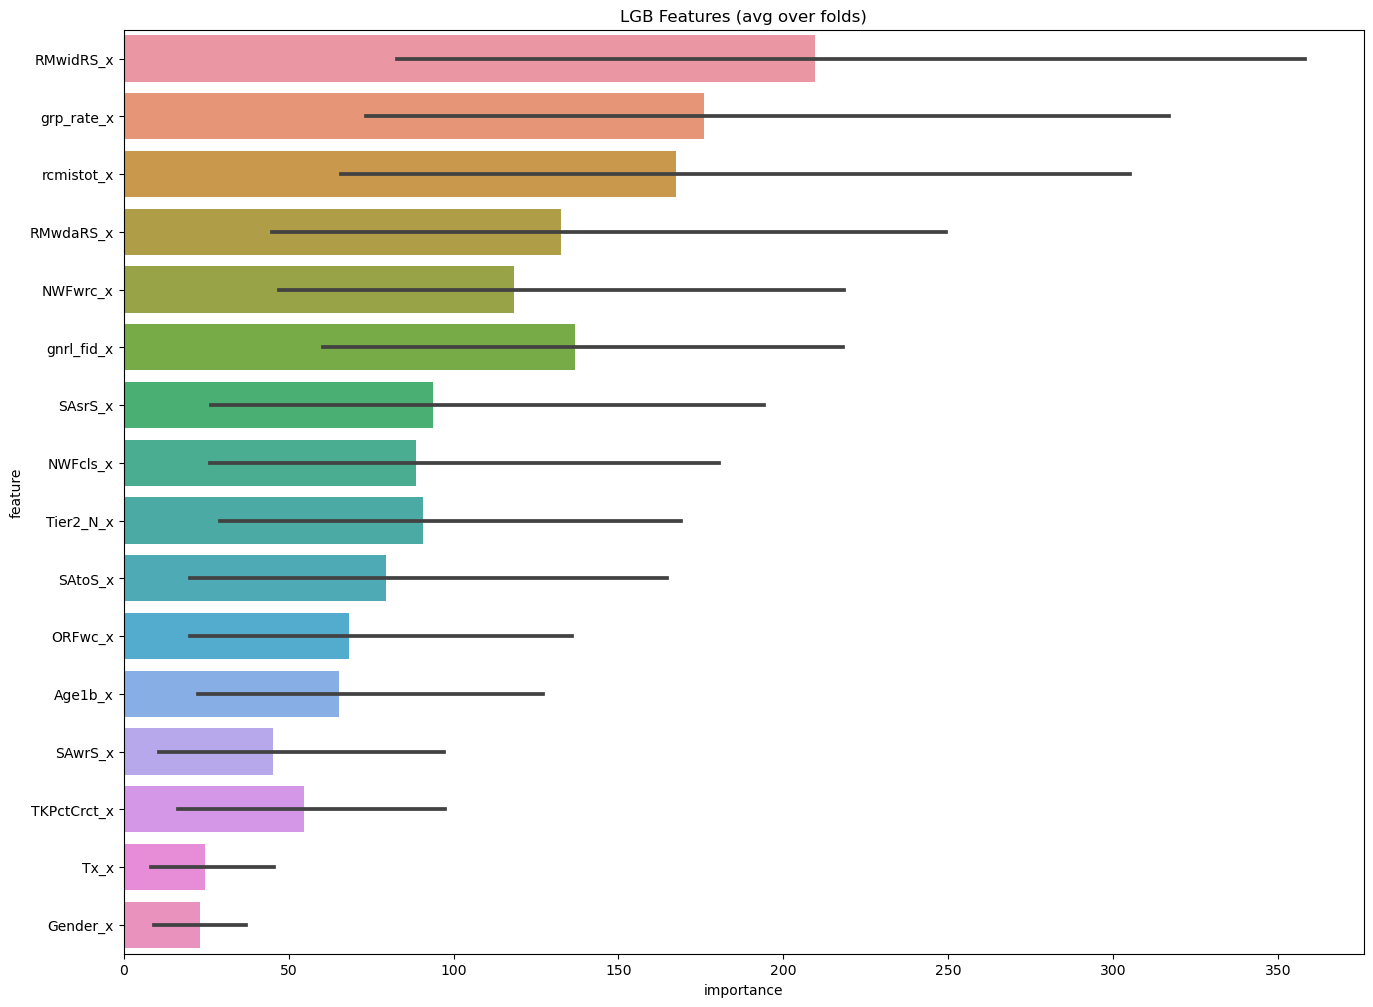

In [8]:
gkf = GroupKFold(n_splits = 5)

target = "RMwidRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_merged[feature_columns], data_merged[target], groups=data_merged.SchlID_x)):
    X_train, y_train = data_merged[feature_columns].iloc[train_idx], data_merged[target].iloc[train_idx]
    X_valid, y_valid = data_merged[feature_columns].iloc[val_idx], data_merged[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = lgb.LGBMClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='binary_error',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

fold 0 training, target :RMwdaRS_target
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[1000]	training's binary_error: 0.0538033	training's binary_logloss: 0.294908	valid_1's binary_error: 0.426471	valid_1's binary_logloss: 0.75001
[2000]	training's binary_error: 0.00371058	training's binary_logloss: 0.171989	valid_1's binary_error: 0.433824	valid

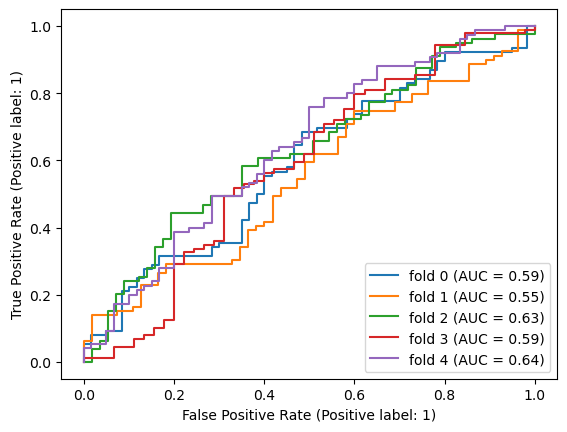

accuracy:0.6223152212792249, specificity: 0.24087187666135038, sensitivity:0.8777223623701552, balanced_score: 0.5592971195157527


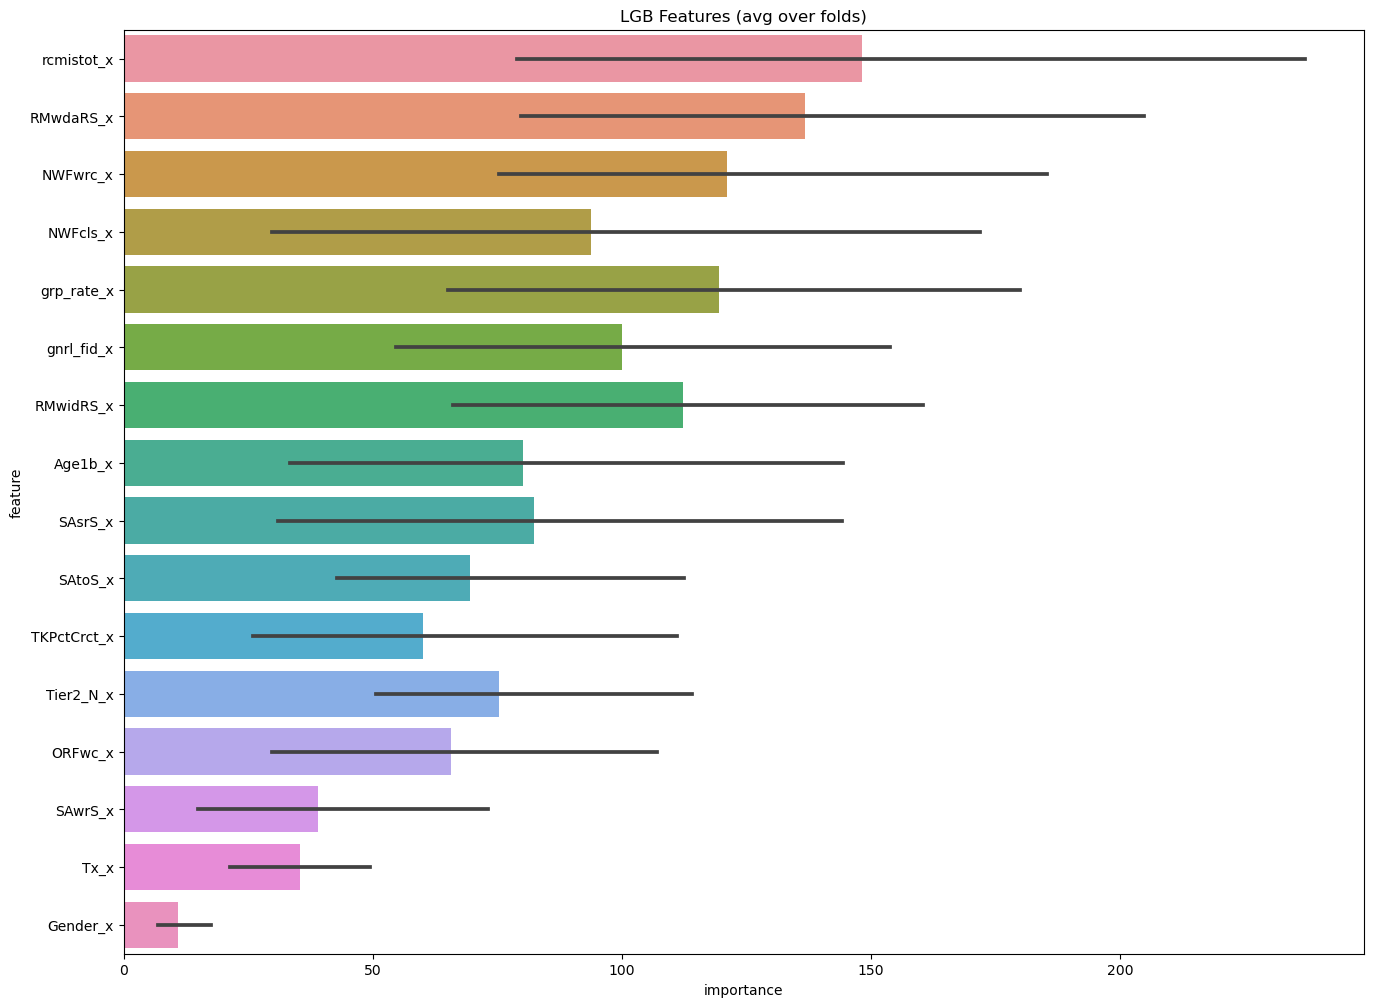

In [9]:
gkf = GroupKFold(n_splits = 5)

target = "RMwdaRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_merged[feature_columns], data_merged[target], groups=data_merged.SchlID_x)):
    X_train, y_train = data_merged[feature_columns].iloc[train_idx], data_merged[target].iloc[train_idx]
    X_valid, y_valid = data_merged[feature_columns].iloc[val_idx], data_merged[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = lgb.LGBMClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='binary_error',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

### All features except Tx

fold 0 training, target :RMwidRS_target
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[1000]	training's binary_error: 0.0538033	training's binary_logloss: 0.3028	valid_1's binary_error: 0.308824	valid_1's binary_logloss: 0.59623
[2000]	training's binary_error: 0.00556586	training's binary_logloss: 0.177426	valid_1's binary_error: 0.330882	valid_1

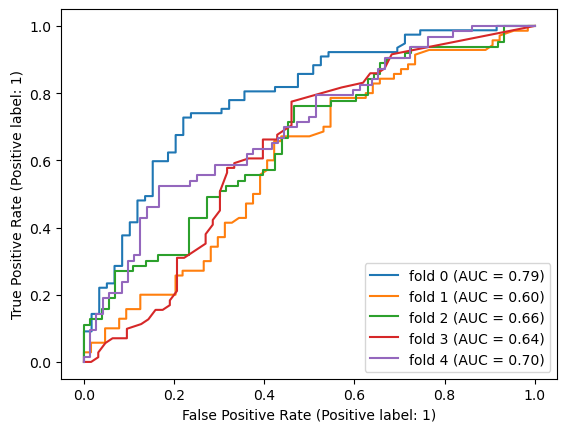

accuracy:0.6650499138295451, specificity: 0.6030096930614983, sensitivity:0.7247708473060586, balanced_score: 0.6638902701837784


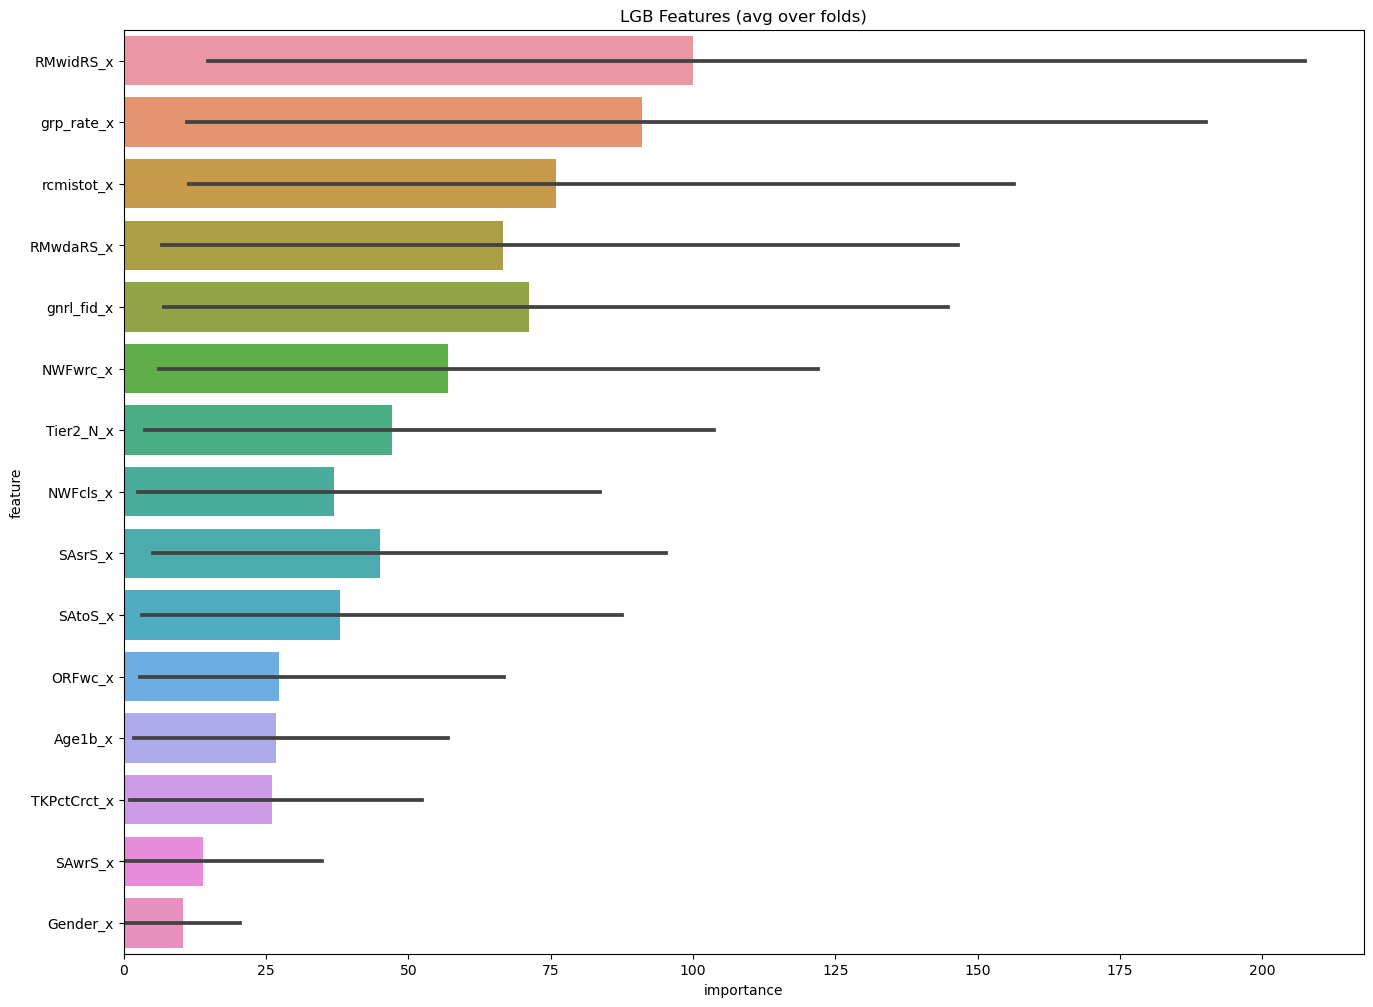

In [10]:
gkf = GroupKFold(n_splits = 5)

target = "RMwidRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_merged[feature_columns_noTx], data_merged[target], groups=data_merged.SchlID_x)):
    X_train, y_train = data_merged[feature_columns_noTx].iloc[train_idx], data_merged[target].iloc[train_idx]
    X_valid, y_valid = data_merged[feature_columns_noTx].iloc[val_idx], data_merged[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = lgb.LGBMClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='binary_error',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_columns_noTx
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

fold 0 training, target :RMwdaRS_target
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[1000]	training's binary_error: 0.0538033	training's binary_logloss: 0.294816	valid_1's binary_error: 0.433824	valid_1's binary_logloss: 0.754236
[2000]	training's binary_error: 0.00371058	training's binary_logloss: 0.16989	valid_1's binary_error: 0.433824	valid

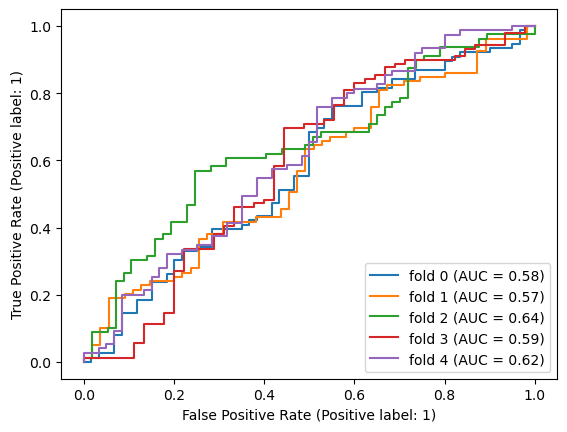

accuracy:0.6297340096901115, specificity: 0.29377458798511424, sensitivity:0.8599600466106242, balanced_score: 0.5768673172978692


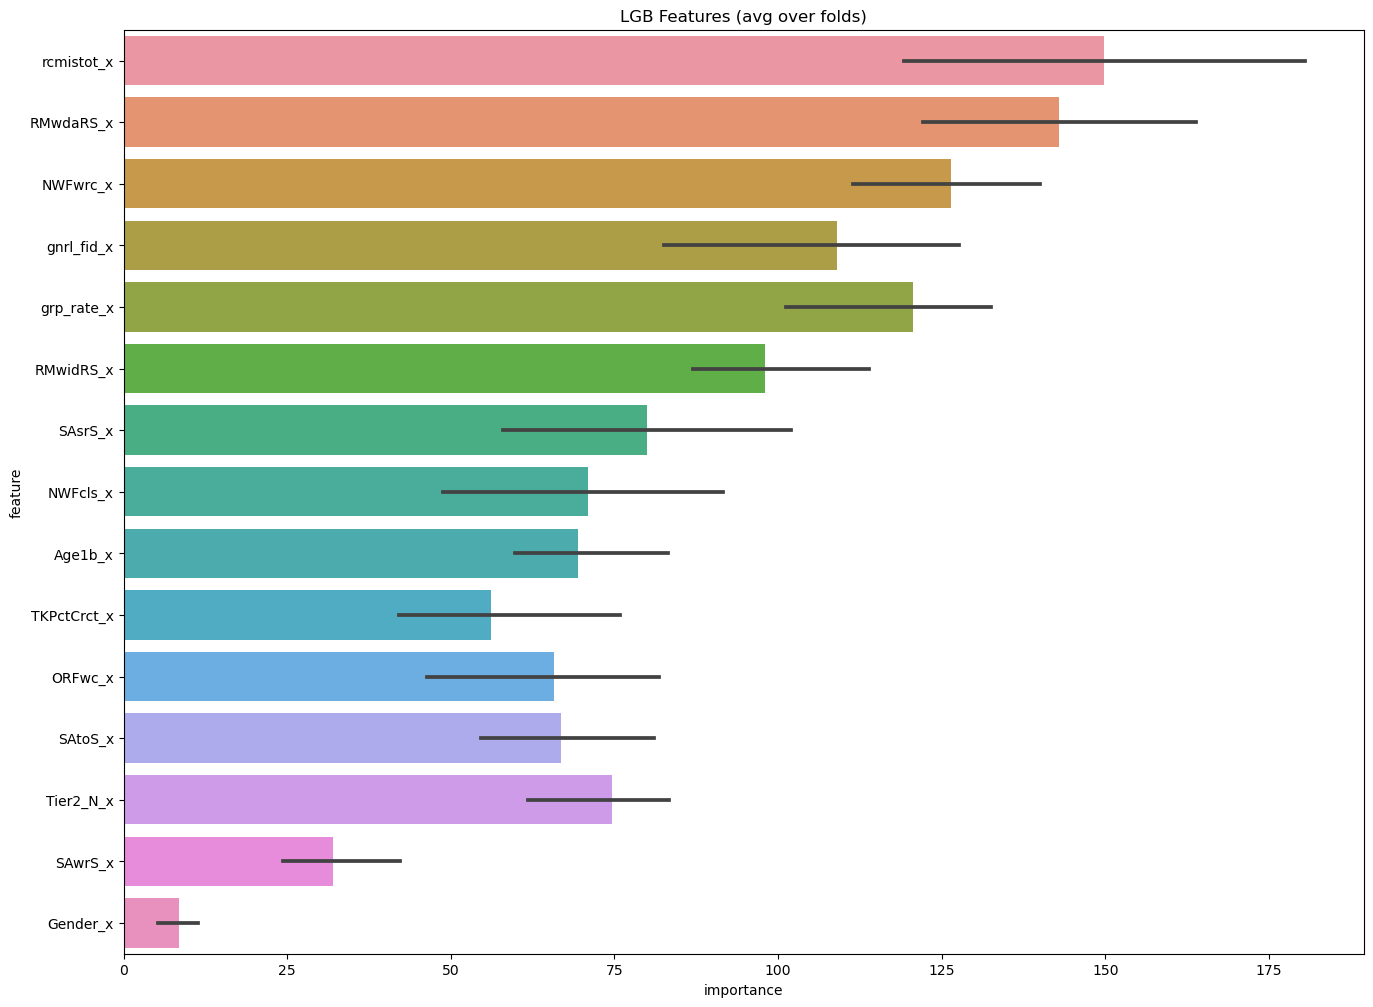

In [11]:
gkf = GroupKFold(n_splits = 5)

target = "RMwdaRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_merged[feature_columns_noTx], data_merged[target], groups=data_merged.SchlID_x)):
    X_train, y_train = data_merged[feature_columns_noTx].iloc[train_idx], data_merged[target].iloc[train_idx]
    X_valid, y_valid = data_merged[feature_columns_noTx].iloc[val_idx], data_merged[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = lgb.LGBMClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='binary_error',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_columns_noTx
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

### Control group

fold 0 training, target :RMwidRS_target
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[1000]	training's binary_error: 0.117241	training's binary_logloss: 0.367667	valid_1's binary_error: 0.223684	valid_1's binary_logloss: 0.585066
[2000]	training's binary_error: 0.0310345	training's binary_logloss: 0.247533	valid_1's binary_error: 0.25	valid_1's 

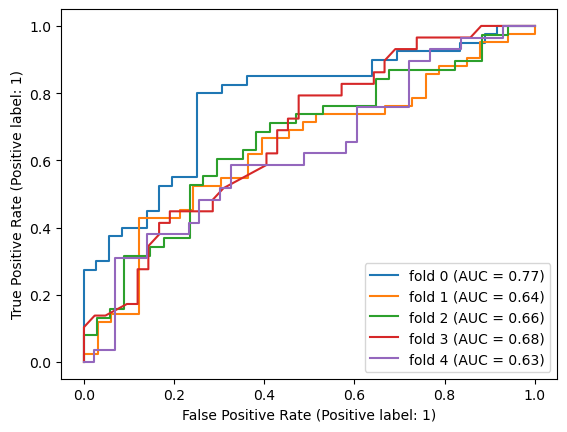

accuracy:0.6523570546083518, specificity: 0.7320242684811769, sensitivity:0.5774401521043989, balanced_score: 0.6547322102927878


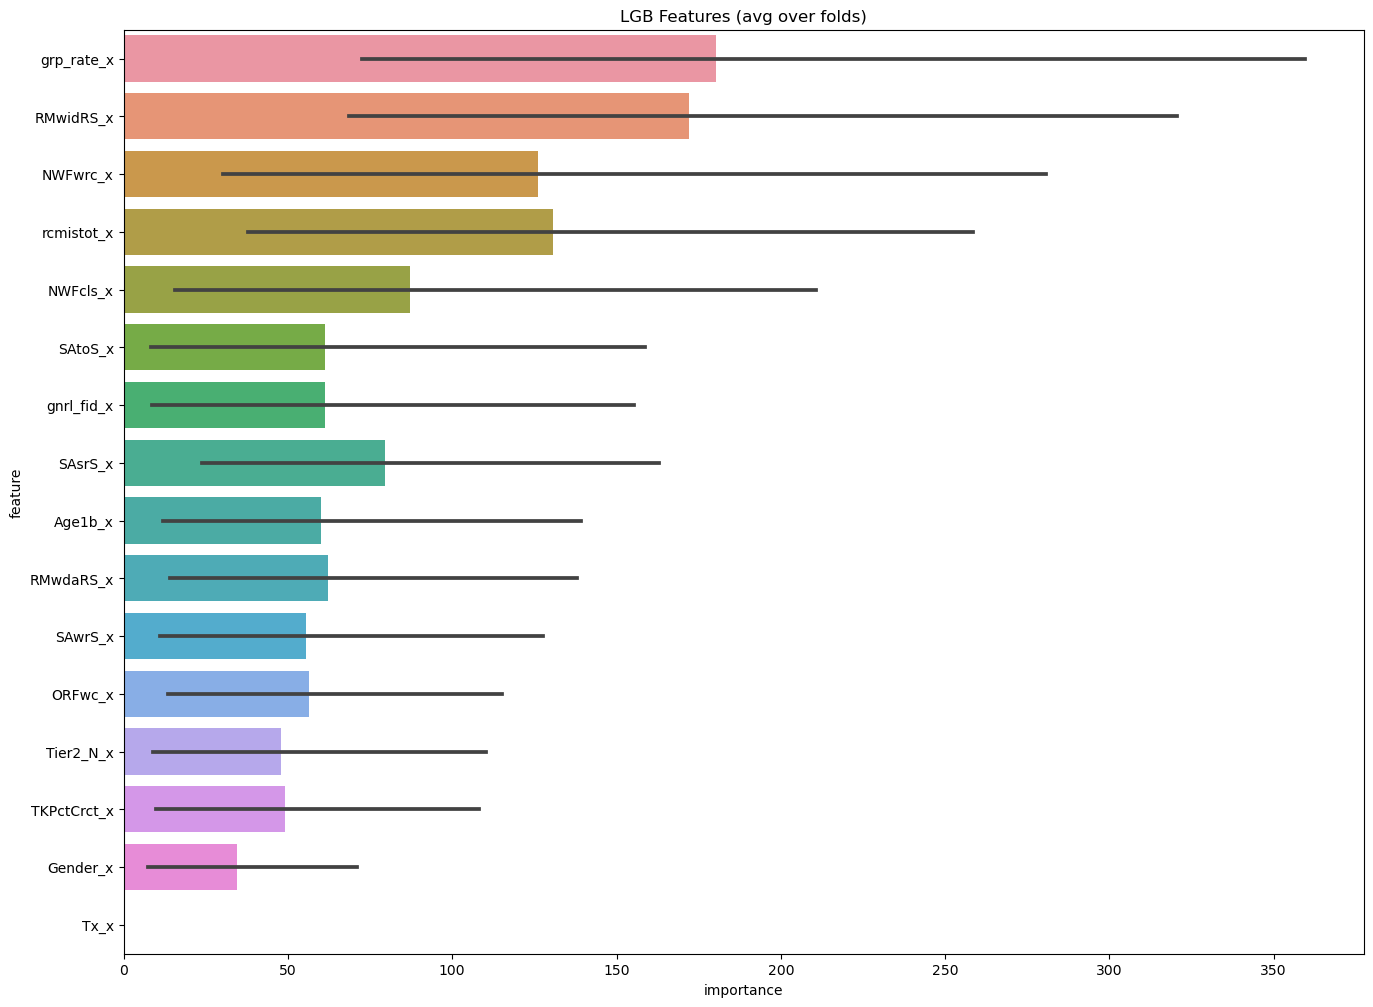

In [12]:
gkf = GroupKFold(n_splits = 5)

target = "RMwidRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_ctrl[feature_columns], data_ctrl[target], groups=data_ctrl.SchlID_x)):
    X_train, y_train = data_ctrl[feature_columns].iloc[train_idx], data_ctrl[target].iloc[train_idx]
    X_valid, y_valid = data_ctrl[feature_columns].iloc[val_idx], data_ctrl[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = lgb.LGBMClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='binary_error',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

fold 0 training, target :RMwdaRS_target
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[1000]	training's binary_error: 0.0793103	training's binary_logloss: 0.370328	valid_1's binary_error: 0.473684	valid_1's binary_logloss: 0.793014
[2000]	training's binary_error: 0.037931	training's binary_logloss: 0.251289	valid_1's binary_error: 0.473684	valid_

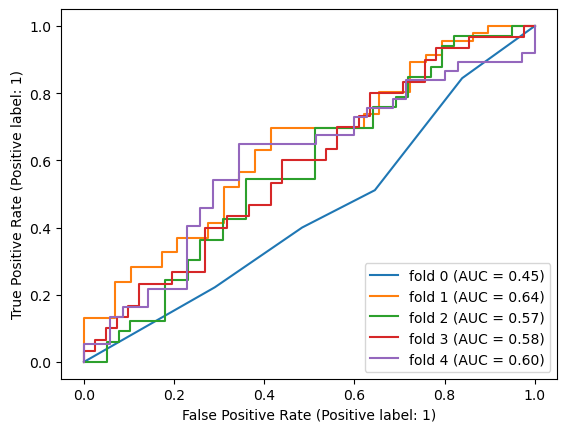

accuracy:0.5699797380775882, specificity: 0.37869049929605014, sensitivity:0.7300231456753196, balanced_score: 0.5543568224856849


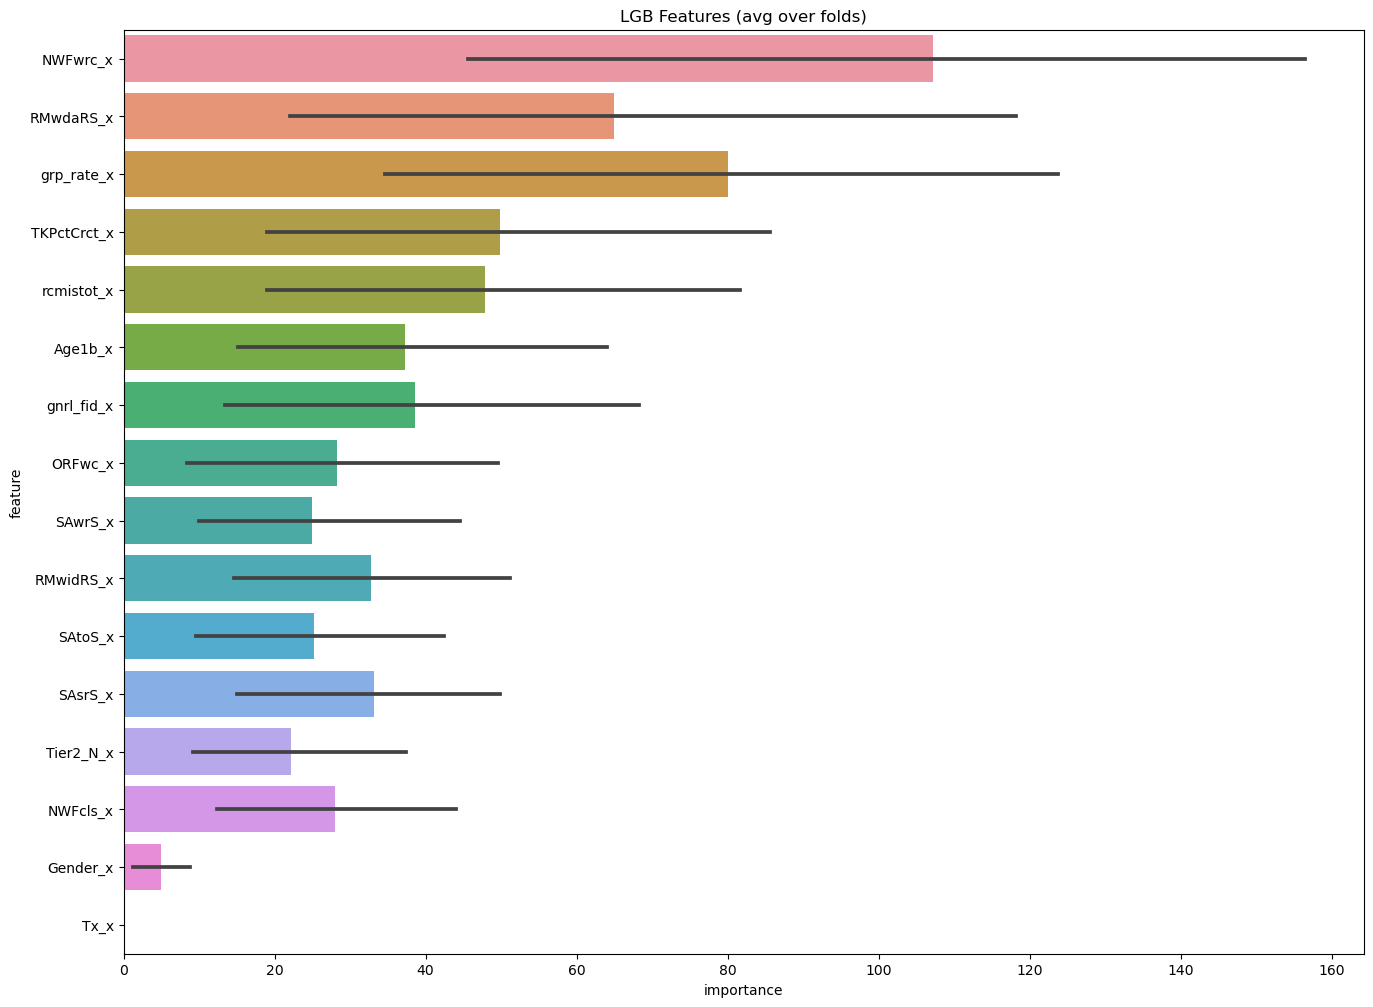

In [13]:
gkf = GroupKFold(n_splits = 5)

target = "RMwdaRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_ctrl[feature_columns], data_ctrl[target], groups=data_ctrl.SchlID_x)):
    X_train, y_train = data_ctrl[feature_columns].iloc[train_idx], data_ctrl[target].iloc[train_idx]
    X_valid, y_valid = data_ctrl[feature_columns].iloc[val_idx], data_ctrl[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = lgb.LGBMClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='binary_error',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

fold 0 training, target :RMwidRS_target
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[1000]	training's binary_error: 0.117241	training's binary_logloss: 0.367667	valid_1's binary_error: 0.223684	valid_1's binary_logloss: 0.585066
[2000]	training's binary_error: 0.0310345	training's binary_logloss: 0.247533	valid_1's binary_error: 0.25	valid_1's 

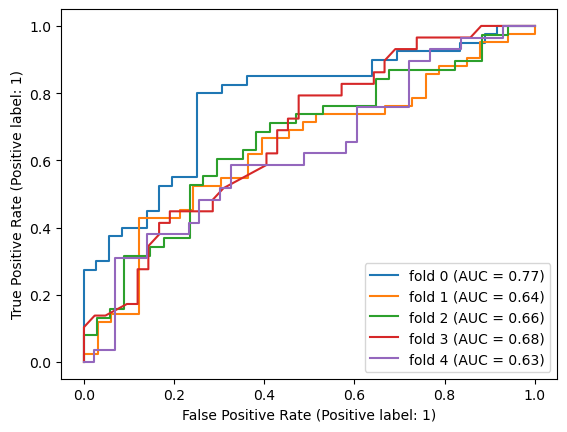

accuracy:0.6523570546083518, specificity: 0.7320242684811769, sensitivity:0.5774401521043989, balanced_score: 0.6547322102927878


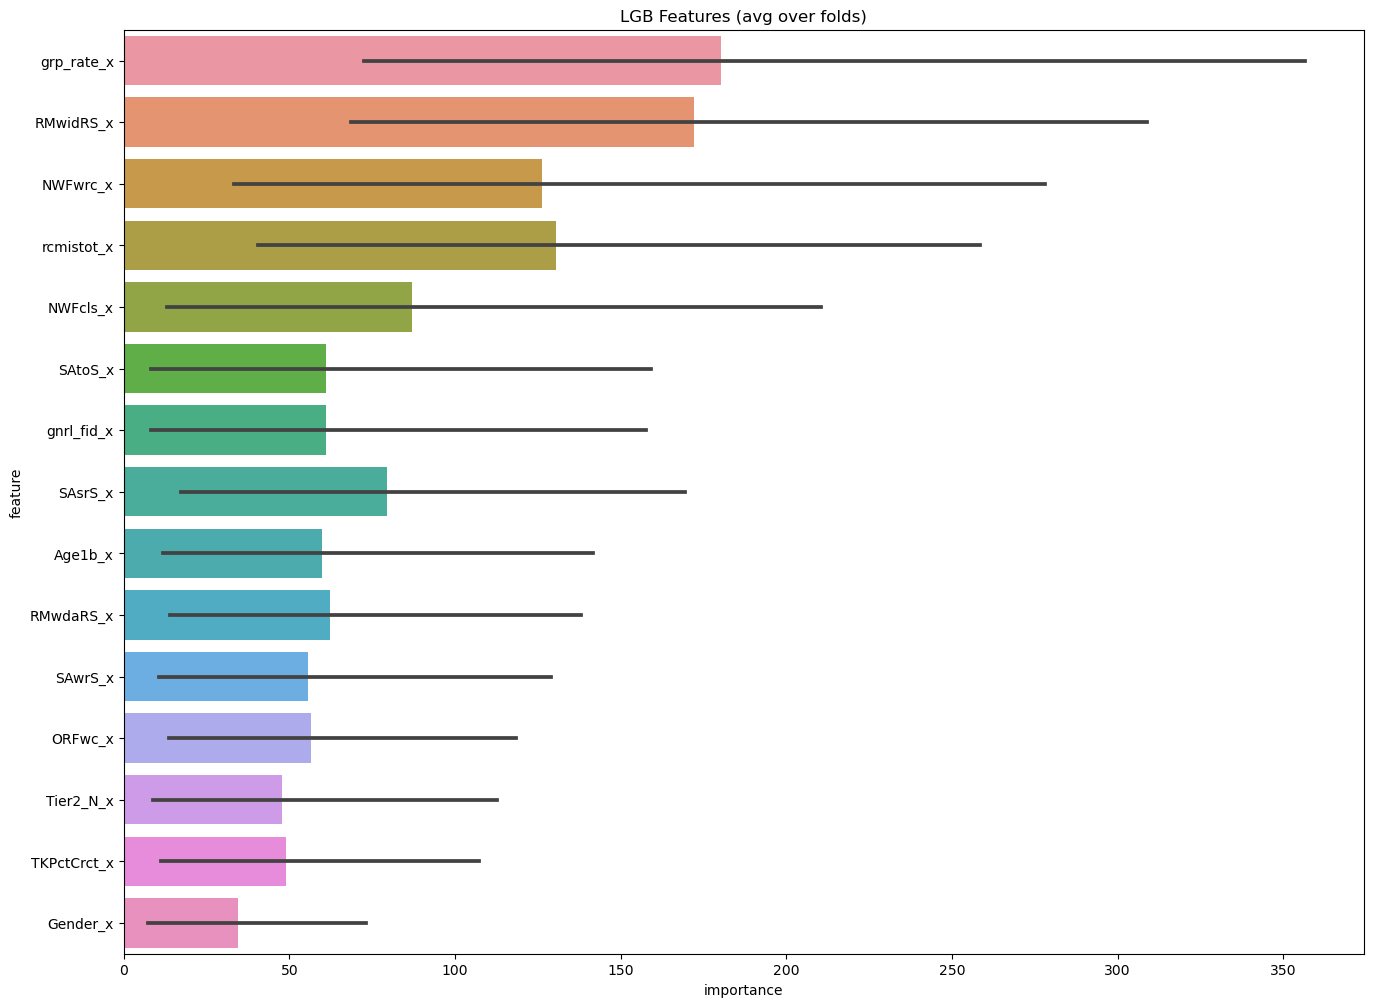

In [14]:
gkf = GroupKFold(n_splits = 5)

target = "RMwidRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_ctrl[feature_columns_noTx], data_ctrl[target], groups=data_ctrl.SchlID_x)):
    X_train, y_train = data_ctrl[feature_columns_noTx].iloc[train_idx], data_ctrl[target].iloc[train_idx]
    X_valid, y_valid = data_ctrl[feature_columns_noTx].iloc[val_idx], data_ctrl[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = lgb.LGBMClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='binary_error',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_columns_noTx
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

fold 0 training, target :RMwdaRS_target
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[1000]	training's binary_error: 0.0793103	training's binary_logloss: 0.370328	valid_1's binary_error: 0.473684	valid_1's binary_logloss: 0.793014
[2000]	training's binary_error: 0.037931	training's binary_logloss: 0.251289	valid_1's binary_error: 0.473684	valid_

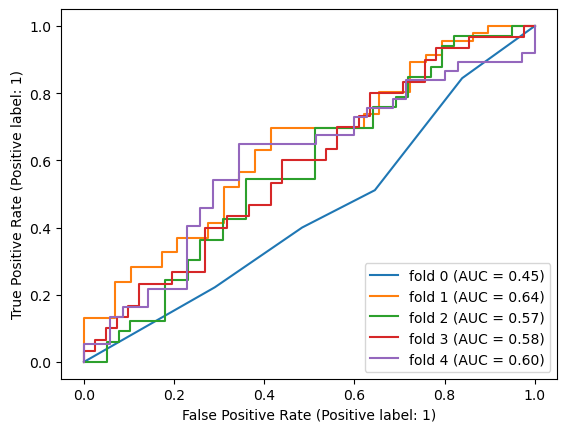

accuracy:0.5699797380775882, specificity: 0.37869049929605014, sensitivity:0.7300231456753196, balanced_score: 0.5543568224856849


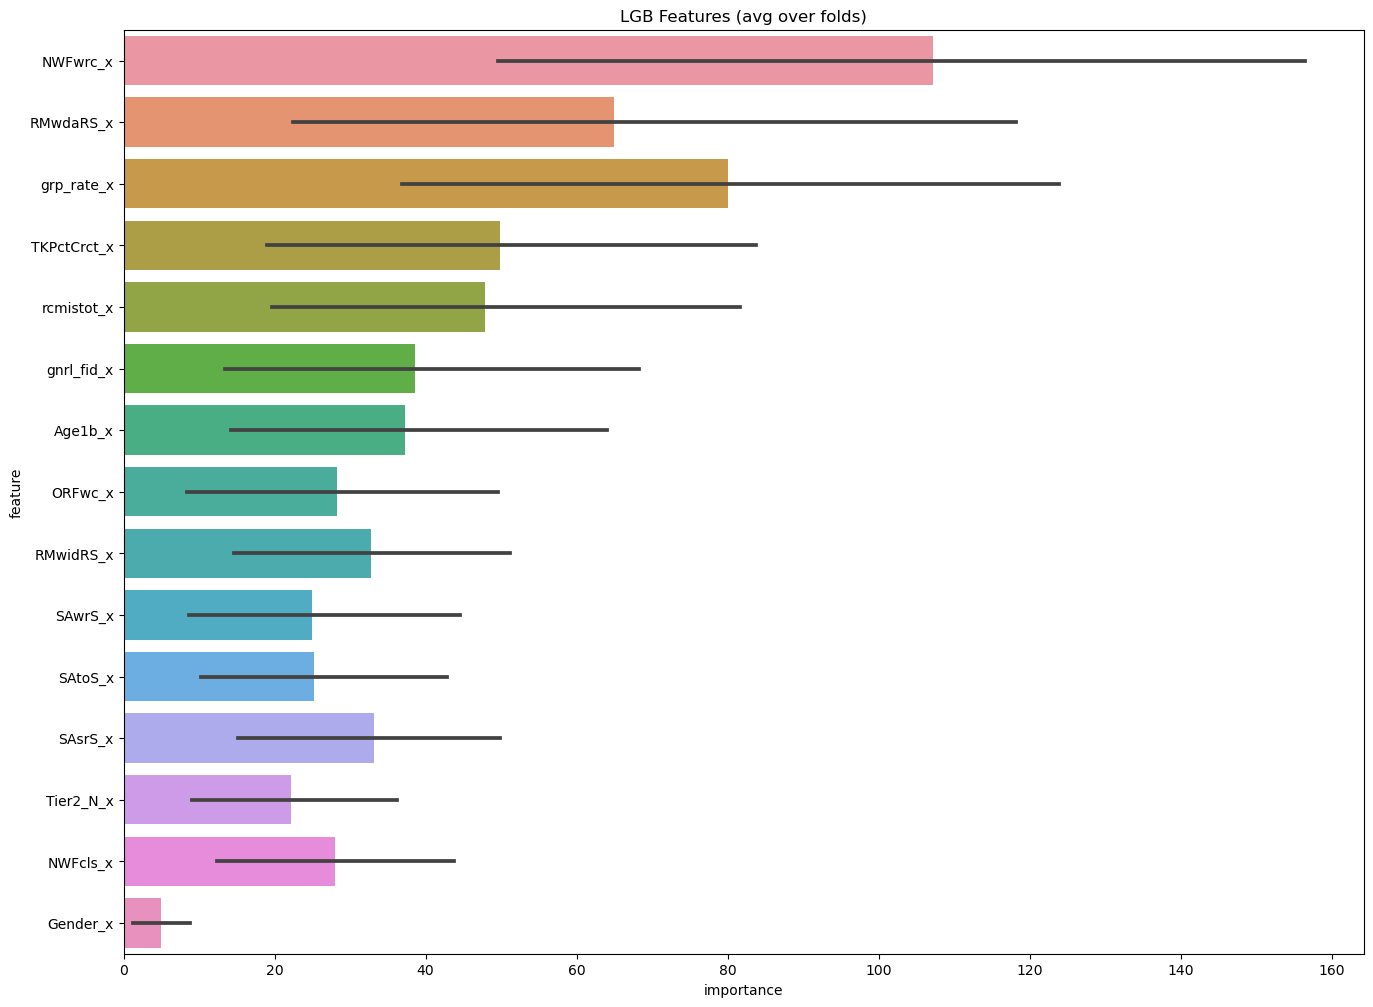

In [15]:
gkf = GroupKFold(n_splits = 5)

target = "RMwdaRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_ctrl[feature_columns_noTx], data_ctrl[target], groups=data_ctrl.SchlID_x)):
    X_train, y_train = data_ctrl[feature_columns_noTx].iloc[train_idx], data_ctrl[target].iloc[train_idx]
    X_valid, y_valid = data_ctrl[feature_columns_noTx].iloc[val_idx], data_ctrl[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = lgb.LGBMClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='binary_error',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_columns_noTx
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

### Intervention group

fold 0 training, target :RMwidRS_target
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[1000]	training's binary_error: 0.0887097	training's binary_logloss: 0.334728	valid_1's binary_error: 0.47541	valid_1's binary_logloss: 0.817264
[2000]	training's binary_error: 0.0322581	training's binary_logloss: 0.225438	valid_1's binary_error: 0.47541	valid_1

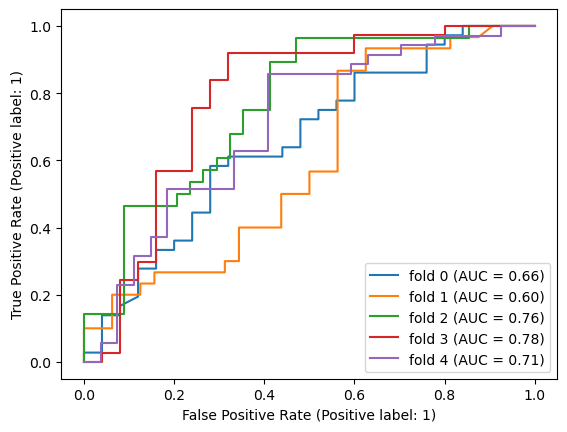

accuracy:0.7085668958223164, specificity: 0.49341557734204794, sensitivity:0.8872758472758473, balanced_score: 0.6903457123089476


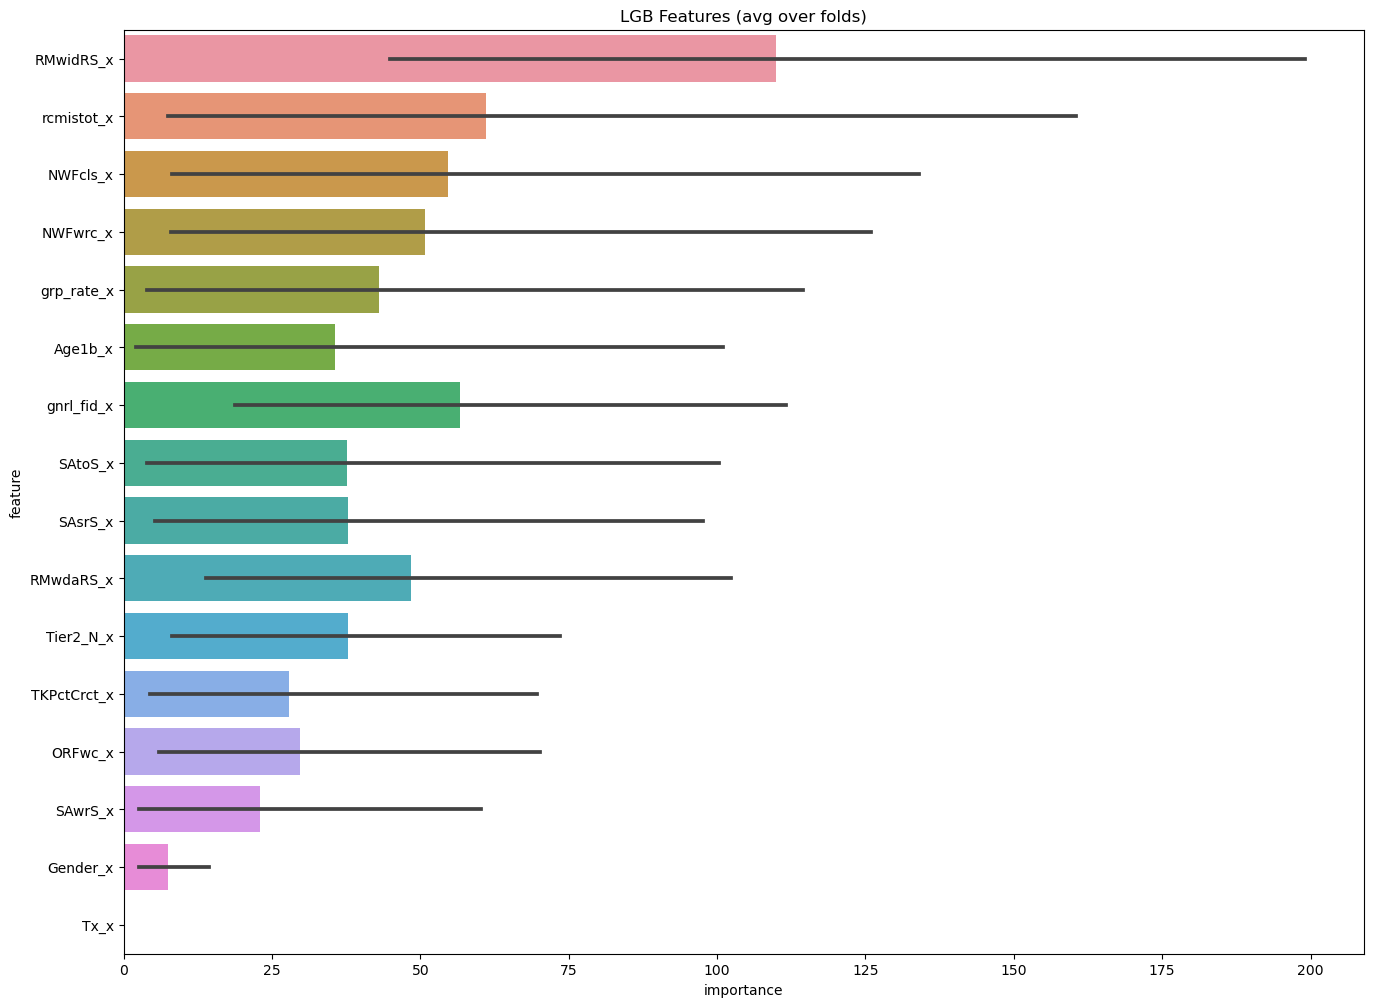

In [16]:
gkf = GroupKFold(n_splits = 5)

target = "RMwidRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_intn[feature_columns], data_intn[target], groups=data_intn.SchlID_x)):
    X_train, y_train = data_intn[feature_columns].iloc[train_idx], data_intn[target].iloc[train_idx]
    X_valid, y_valid = data_intn[feature_columns].iloc[val_idx], data_intn[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = lgb.LGBMClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='binary_error',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

fold 0 training, target :RMwdaRS_target
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[1000]	training's binary_error: 0.0806452	training's binary_logloss: 0.335522	valid_1's binary_error: 0.360656	valid_1's binary_logloss: 0.632483
[2000]	training's binary_error: 0.0241935	training's binary_logloss: 0.223864	valid_1's binary_error: 0.360656	valid

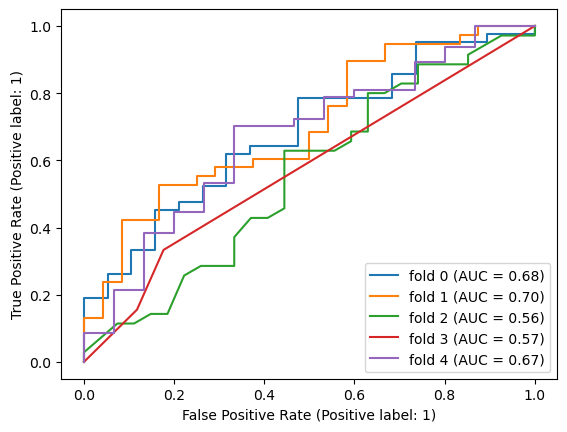

accuracy:0.6957694341618191, specificity: 0.1143859649122807, sensitivity:0.9799498746867169, balanced_score: 0.5471679197994987


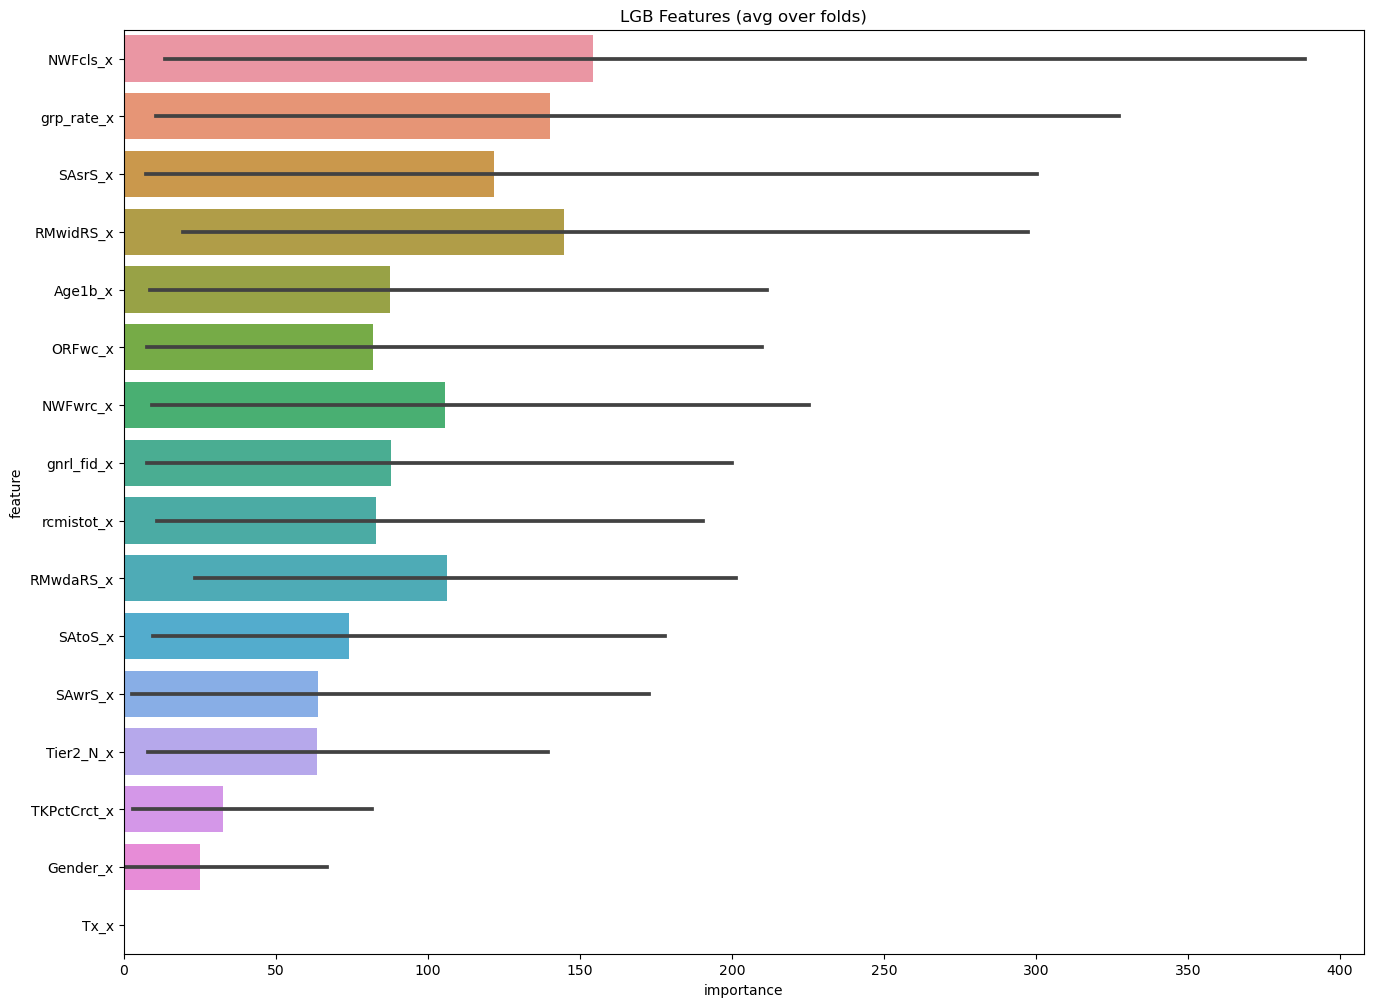

In [17]:
gkf = GroupKFold(n_splits = 5)

target = "RMwdaRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_intn[feature_columns], data_intn[target], groups=data_intn.SchlID_x)):
    X_train, y_train = data_intn[feature_columns].iloc[train_idx], data_intn[target].iloc[train_idx]
    X_valid, y_valid = data_intn[feature_columns].iloc[val_idx], data_intn[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = lgb.LGBMClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='binary_error',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

fold 0 training, target :RMwidRS_target
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[1000]	training's binary_error: 0.0887097	training's binary_logloss: 0.334728	valid_1's binary_error: 0.47541	valid_1's binary_logloss: 0.817264
[2000]	training's binary_error: 0.0322581	training's binary_logloss: 0.225438	valid_1's binary_error: 0.47541	valid_1

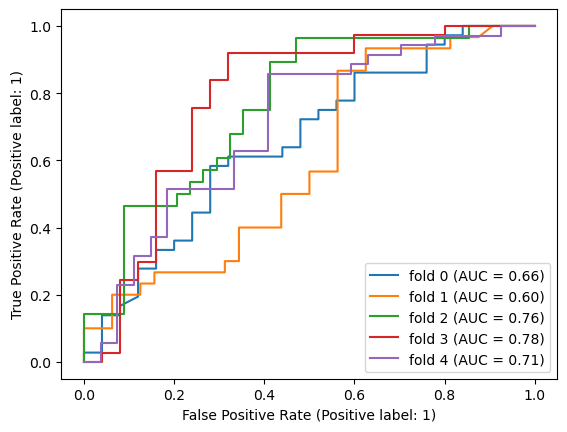

accuracy:0.7085668958223164, specificity: 0.49341557734204794, sensitivity:0.8872758472758473, balanced_score: 0.6903457123089476


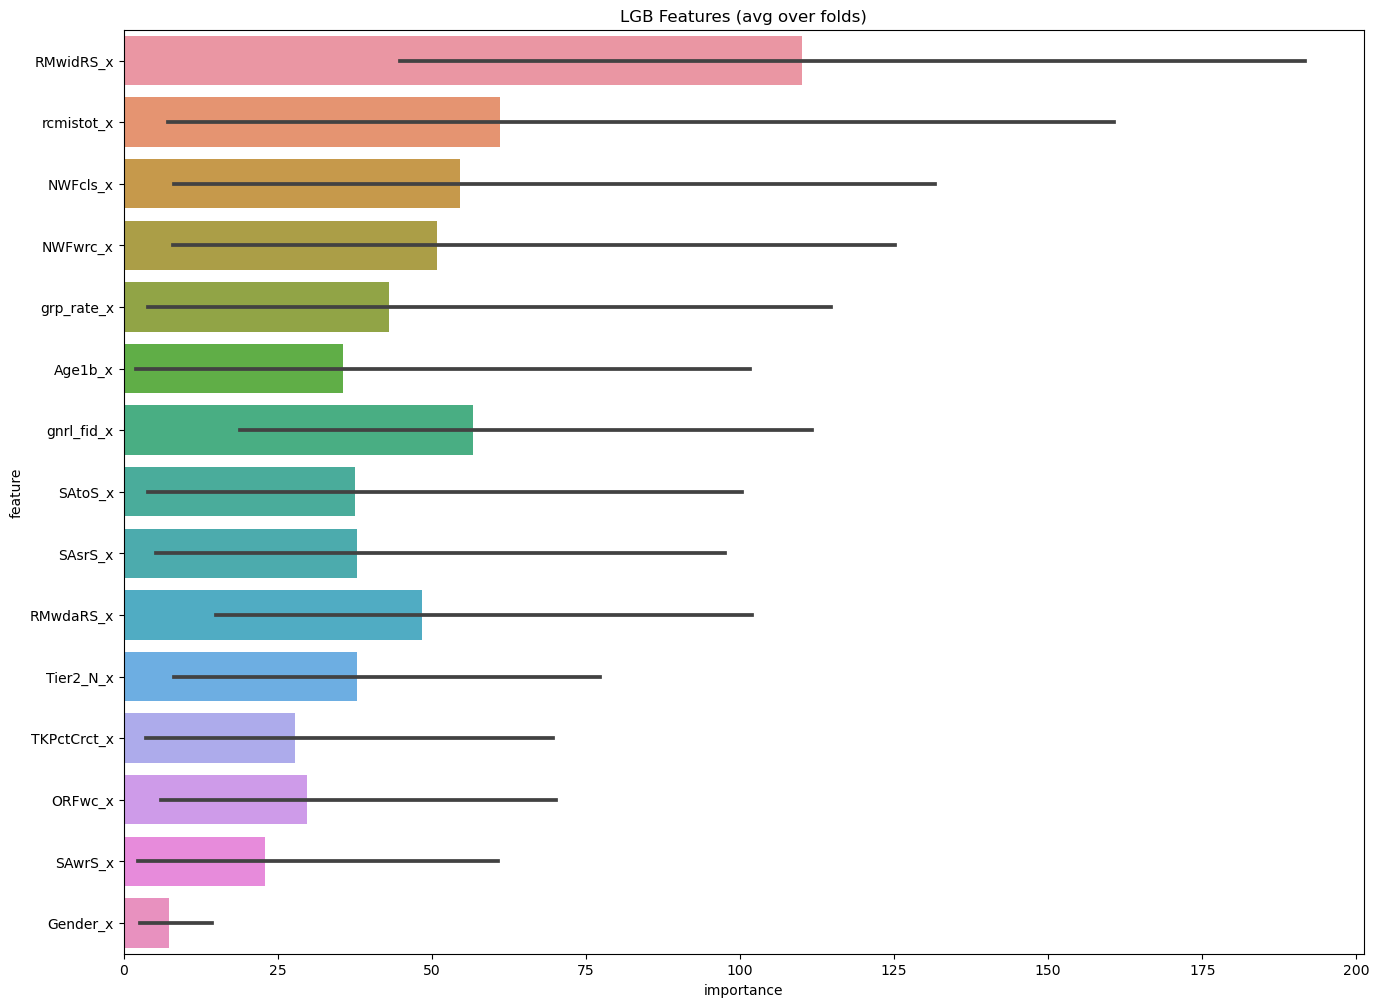

In [18]:
gkf = GroupKFold(n_splits = 5)

target = "RMwidRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_intn[feature_columns_noTx], data_intn[target], groups=data_intn.SchlID_x)):
    X_train, y_train = data_intn[feature_columns_noTx].iloc[train_idx], data_intn[target].iloc[train_idx]
    X_valid, y_valid = data_intn[feature_columns_noTx].iloc[val_idx], data_intn[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = lgb.LGBMClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='binary_error',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_columns_noTx
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

fold 0 training, target :RMwdaRS_target
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[1000]	training's binary_error: 0.0806452	training's binary_logloss: 0.335522	valid_1's binary_error: 0.360656	valid_1's binary_logloss: 0.632483
[2000]	training's binary_error: 0.0241935	training's binary_logloss: 0.223864	valid_1's binary_error: 0.360656	valid

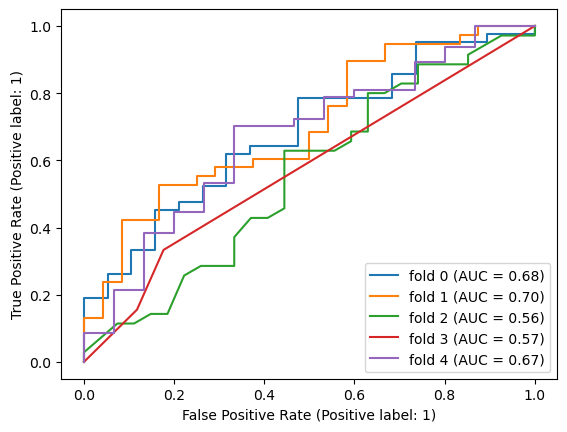

accuracy:0.6957694341618191, specificity: 0.1143859649122807, sensitivity:0.9799498746867169, balanced_score: 0.5471679197994987


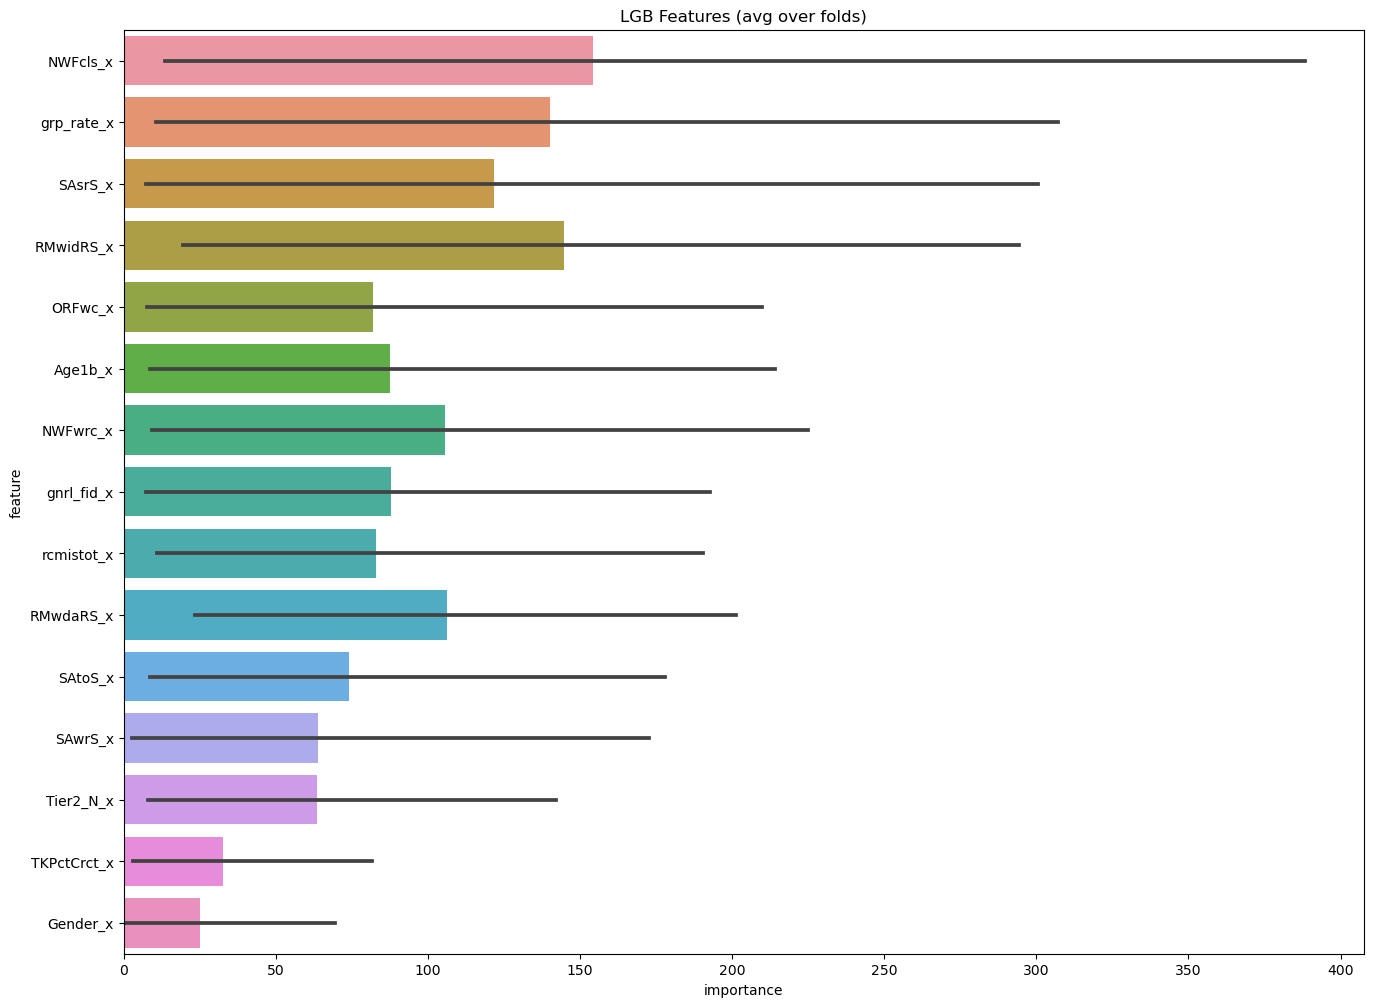

In [19]:
gkf = GroupKFold(n_splits = 5)

target = "RMwdaRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_intn[feature_columns_noTx], data_intn[target], groups=data_intn.SchlID_x)):
    X_train, y_train = data_intn[feature_columns_noTx].iloc[train_idx], data_intn[target].iloc[train_idx]
    X_valid, y_valid = data_intn[feature_columns_noTx].iloc[val_idx], data_intn[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = lgb.LGBMClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='binary_error',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_columns_noTx
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

### Only selected features

fold 0 training, target :RMwidRS_target
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[1000]	training's binary_error: 0.12987	training's binary_logloss: 0.406893	valid_1's binary_error: 0.345588	valid_1's binary_logloss: 0.641135
[2000]	training's binary_error: 0.0686456	training's binary_logloss: 0.304346	valid_1's binary_error: 0.360294	valid_1

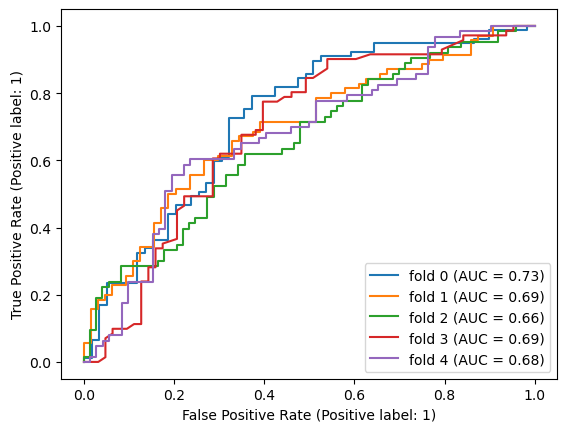

accuracy:0.6578725652781843, specificity: 0.6049343814609661, sensitivity:0.7105428530780643, balanced_score: 0.6577386172695152


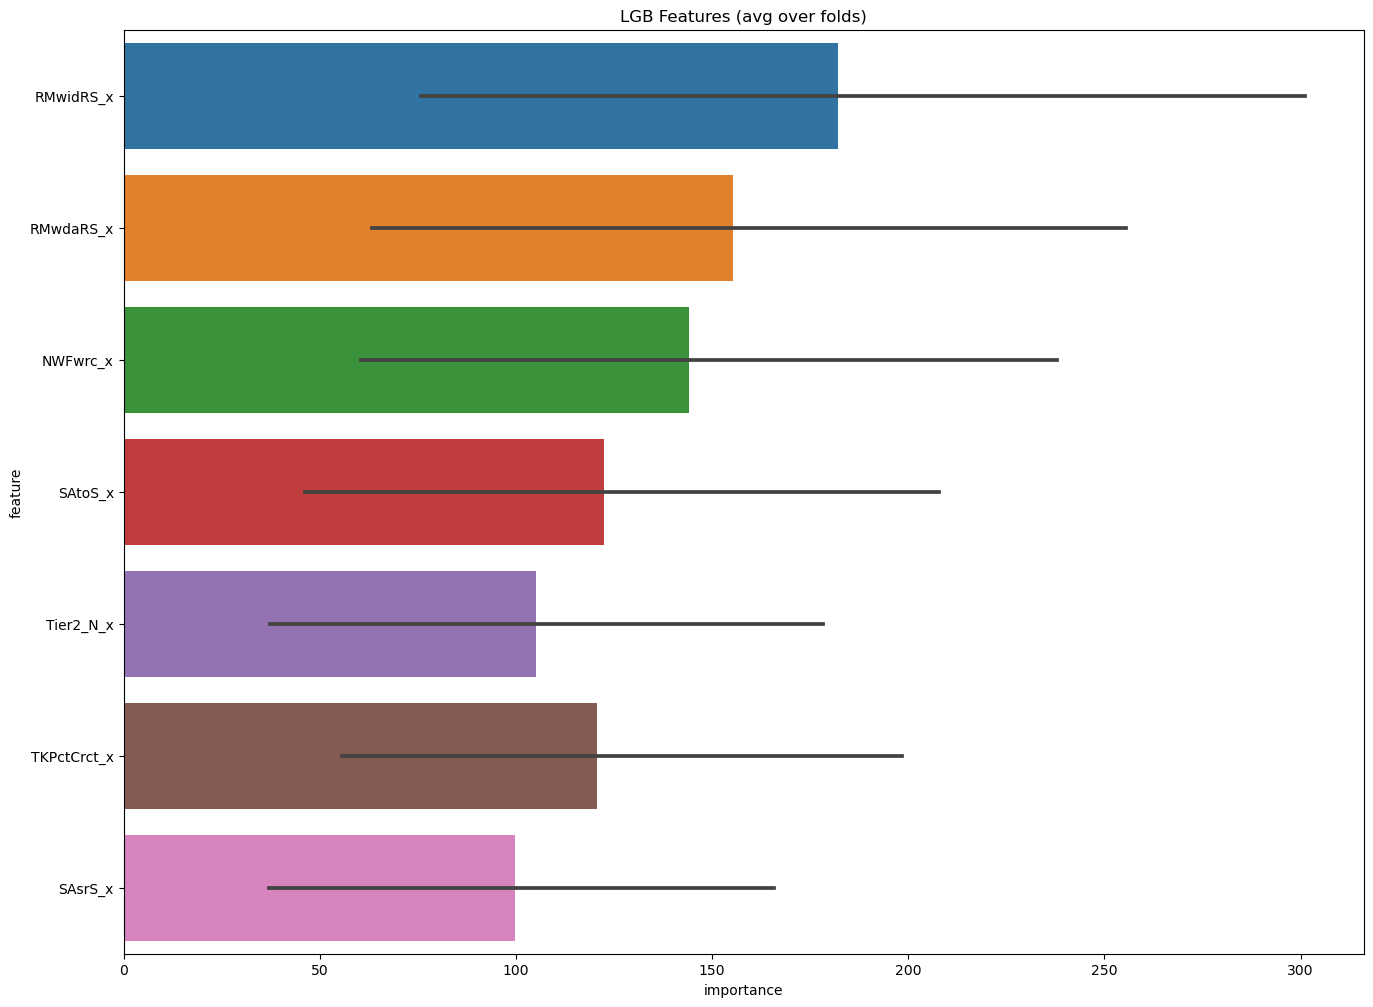

In [20]:
gkf = GroupKFold(n_splits = 5)

target = "RMwidRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_merged[selected_features_wid], data_merged[target], groups=data_merged.SchlID_x)):
    X_train, y_train = data_merged[selected_features_wid].iloc[train_idx], data_merged[target].iloc[train_idx]
    X_valid, y_valid = data_merged[selected_features_wid].iloc[val_idx], data_merged[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = lgb.LGBMClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='binary_error',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = selected_features_wid
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

fold 0 training, target :RMwidRS_target
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[1000]	training's binary_error: 0.2	training's binary_logloss: 0.468628	valid_1's binary_error: 0.328947	valid_1's binary_logloss: 0.599619
[2000]	training's binary_error: 0.131034	training's binary_logloss: 0.381608	valid_1's binary_error: 0.315789	valid_1's bi

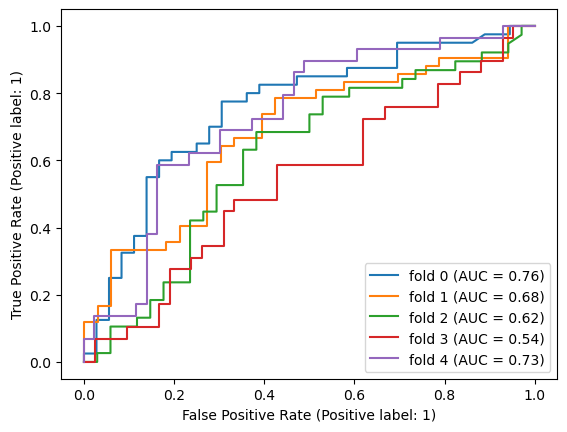

accuracy:0.6383225434478214, specificity: 0.6629430912604647, sensitivity:0.6183761126955319, balanced_score: 0.6406596019779983


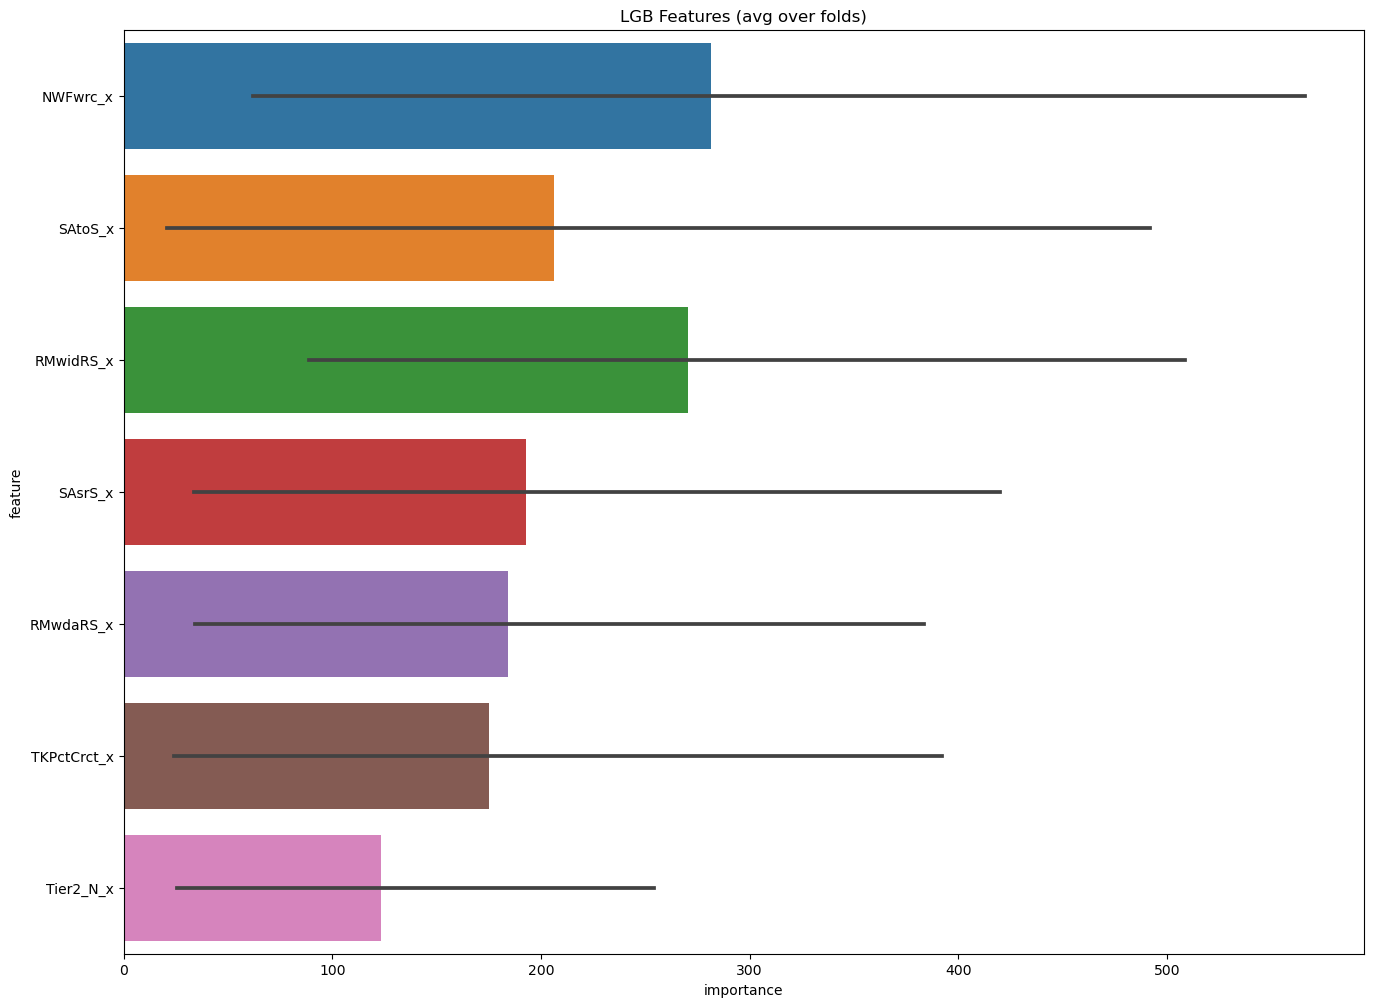

In [21]:
gkf = GroupKFold(n_splits = 5)

target = "RMwidRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_ctrl[selected_features_wid], data_ctrl[target], groups=data_ctrl.SchlID_x)):
    X_train, y_train = data_ctrl[selected_features_wid].iloc[train_idx], data_ctrl[target].iloc[train_idx]
    X_valid, y_valid = data_ctrl[selected_features_wid].iloc[val_idx], data_ctrl[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = lgb.LGBMClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='binary_error',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = selected_features_wid
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

fold 0 training, target :RMwidRS_target
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[1000]	training's binary_error: 0.169355	training's binary_logloss: 0.409559	valid_1's binary_error: 0.459016	valid_1's binary_logloss: 0.694147
[2000]	training's binary_error: 0.120968	training's binary_logloss: 0.332701	valid_1's binary_error: 0.491803	valid_1

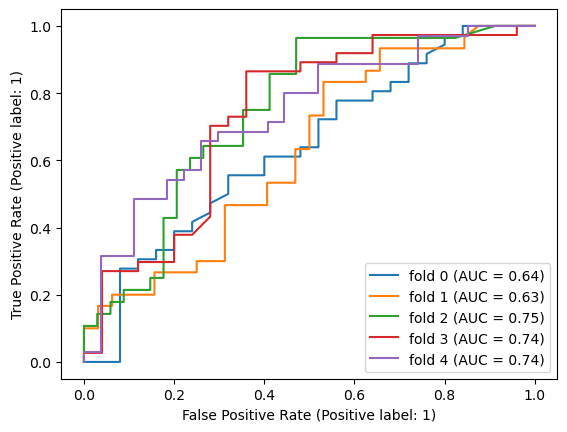

accuracy:0.6795346377578, specificity: 0.467400871459695, sensitivity:0.8640840840840841, balanced_score: 0.6657424777718897


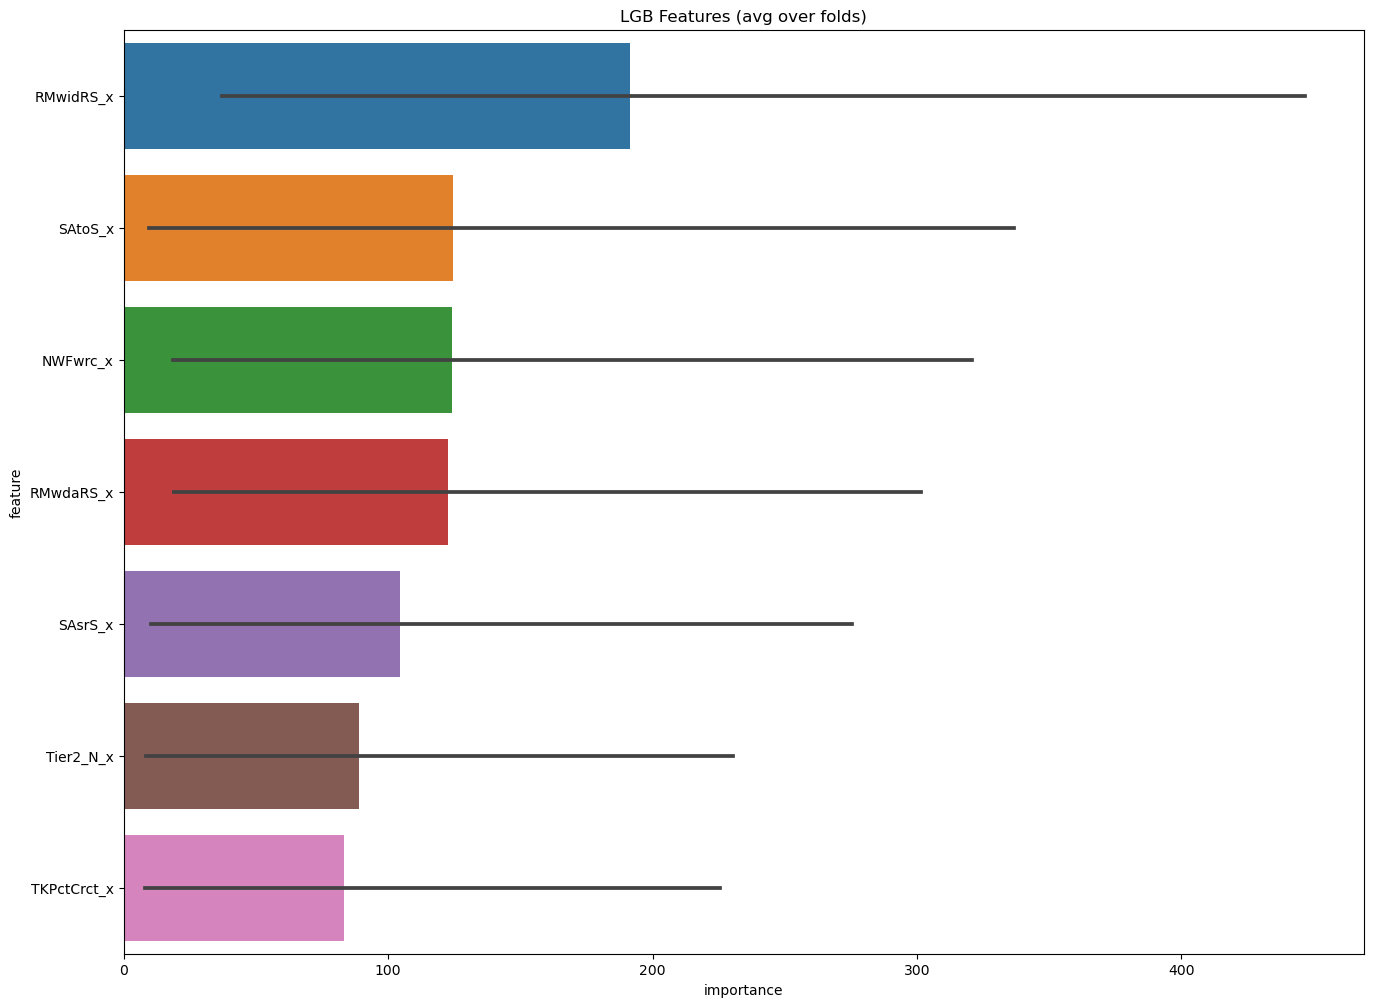

In [22]:
gkf = GroupKFold(n_splits = 5)

target = "RMwidRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_intn[selected_features_wid], data_intn[target], groups=data_intn.SchlID_x)):
    X_train, y_train = data_intn[selected_features_wid].iloc[train_idx], data_intn[target].iloc[train_idx]
    X_valid, y_valid = data_intn[selected_features_wid].iloc[val_idx], data_intn[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = lgb.LGBMClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='binary_error',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = selected_features_wid
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

fold 0 training, target :RMwdaRS_target
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[1000]	training's binary_error: 0.185529	training's binary_logloss: 0.451015	valid_1's binary_error: 0.441176	valid_1's binary_logloss: 0.737277
[2000]	training's binary_error: 0.12616	training's binary_logloss: 0.367814	valid_1's binary_error: 0.448529	valid_1'

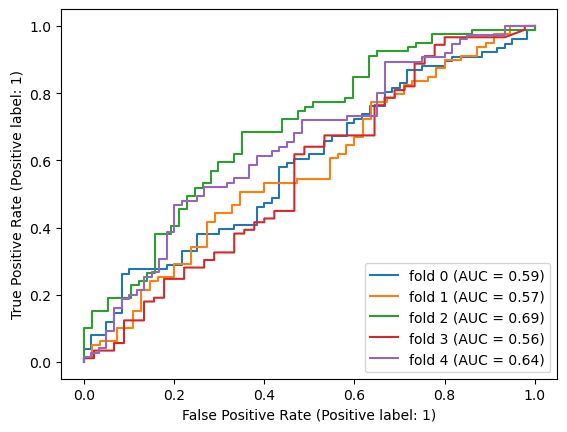

accuracy:0.6445276883556076, specificity: 0.21318979266347687, sensitivity:0.940546013020034, balanced_score: 0.5768679028417555


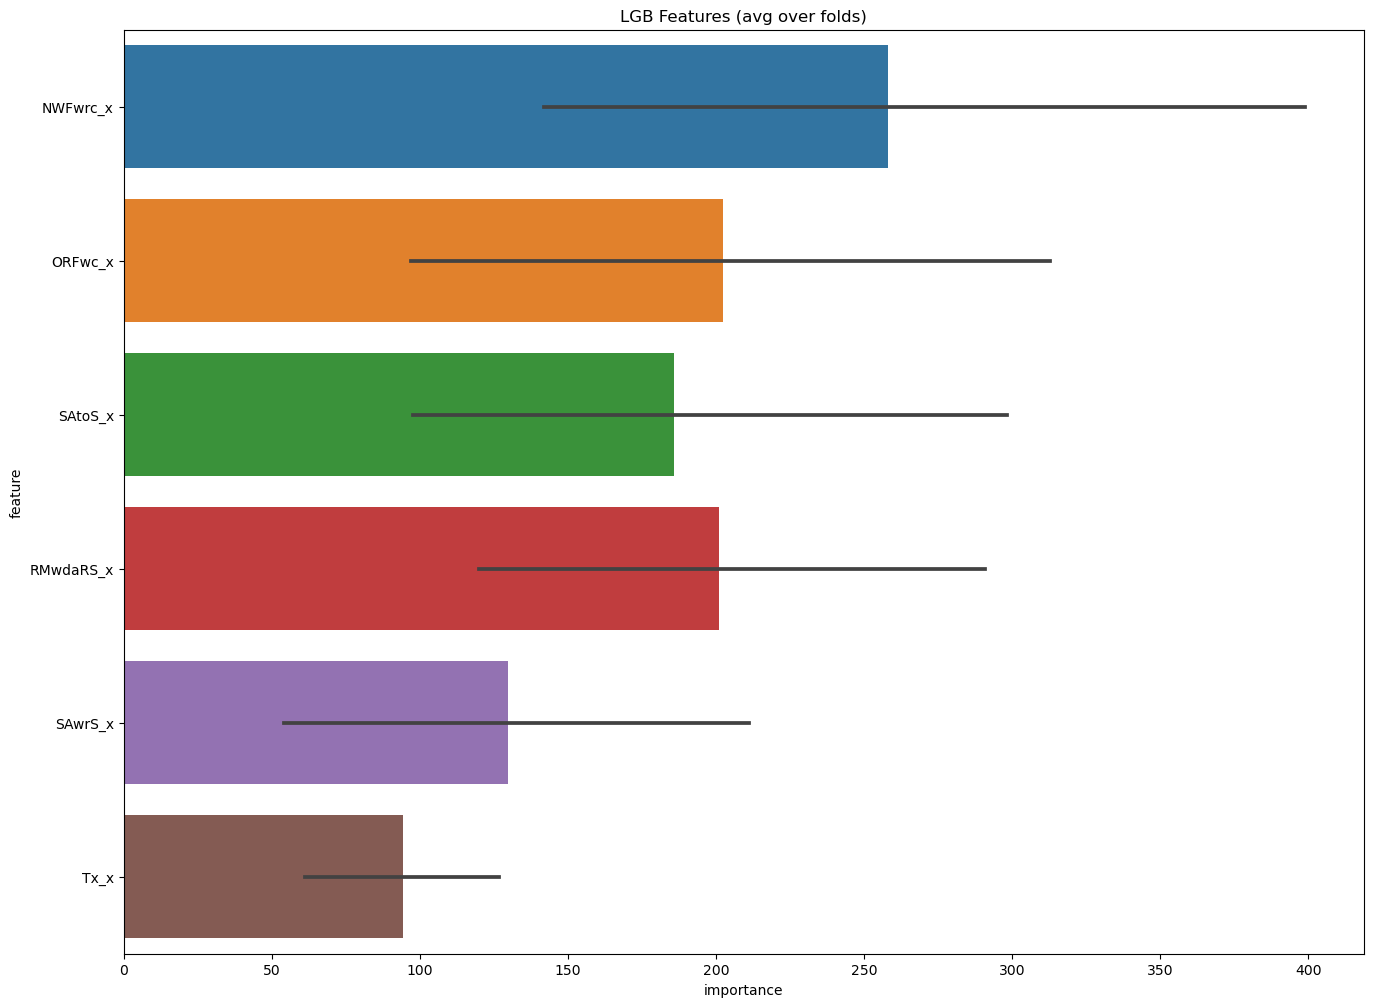

In [23]:
gkf = GroupKFold(n_splits = 5)

target = "RMwdaRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_merged[selected_features_wda], data_merged[target], groups=data_merged.SchlID_x)):
    X_train, y_train = data_merged[selected_features_wda].iloc[train_idx], data_merged[target].iloc[train_idx]
    X_valid, y_valid = data_merged[selected_features_wda].iloc[val_idx], data_merged[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = lgb.LGBMClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='binary_error',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = selected_features_wda
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

fold 0 training, target :RMwdaRS_target
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[1000]	training's binary_error: 0.213793	training's binary_logloss: 0.50863	valid_1's binary_error: 0.460526	valid_1's binary_logloss: 0.737011
[2000]	training's binary_error: 0.165517	training's binary_logloss: 0.435999	valid_1's binary_error: 0.473684	valid_1'

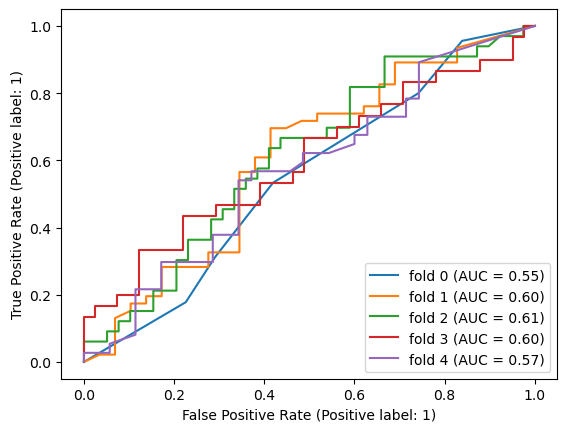

accuracy:0.5916851165472367, specificity: 0.34151588267218097, sensitivity:0.8255896212417951, balanced_score: 0.5835527519569881


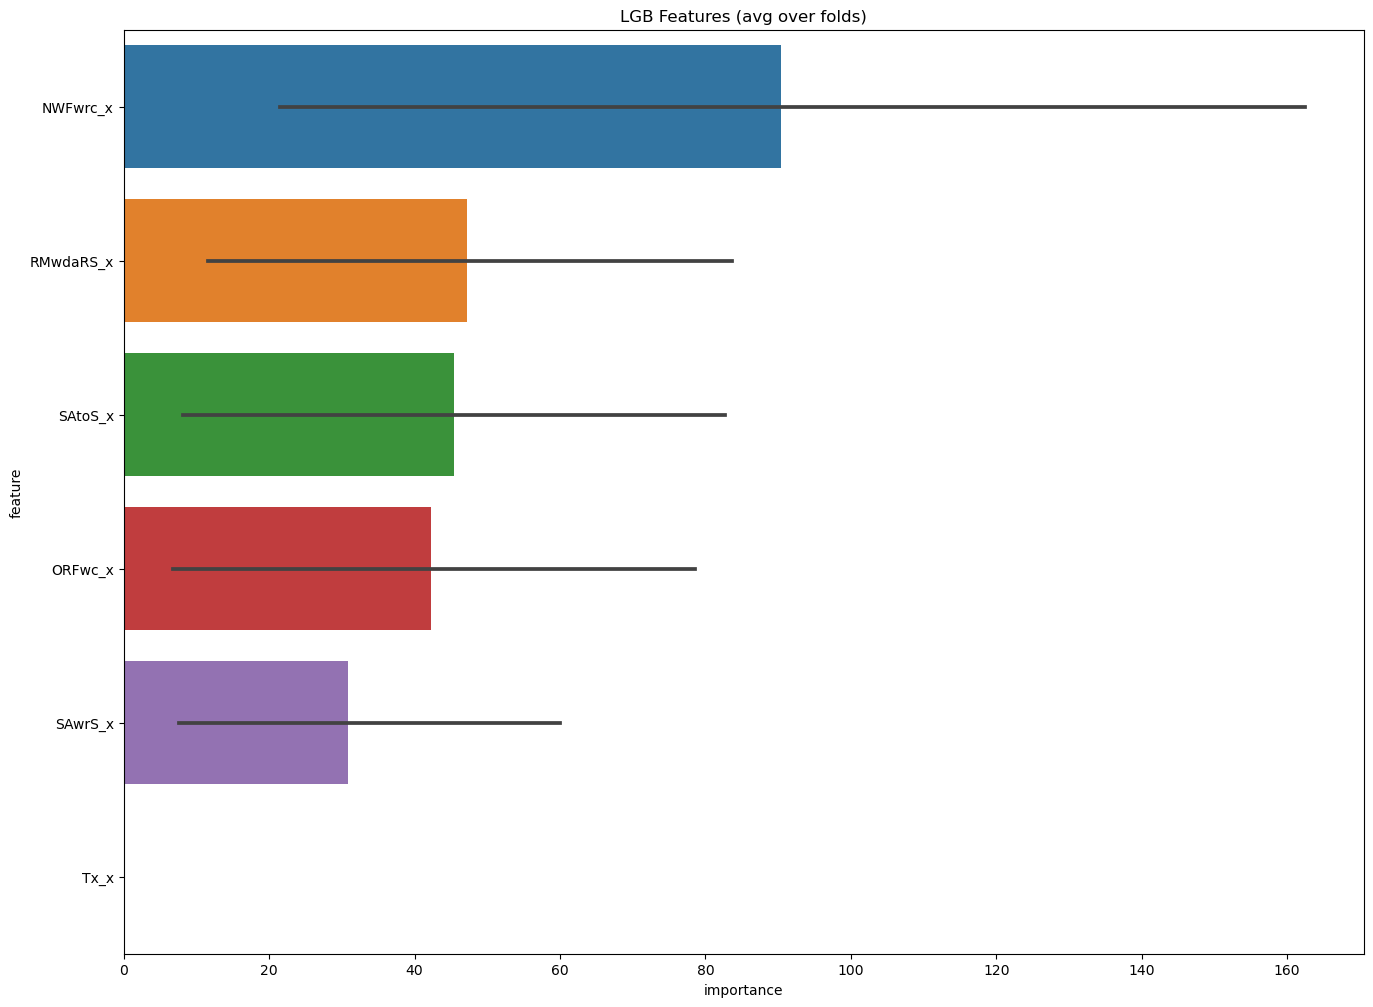

In [24]:
gkf = GroupKFold(n_splits = 5)

target = "RMwdaRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_ctrl[selected_features_wda], data_ctrl[target], groups=data_ctrl.SchlID_x)):
    X_train, y_train = data_ctrl[selected_features_wda].iloc[train_idx], data_ctrl[target].iloc[train_idx]
    X_valid, y_valid = data_ctrl[selected_features_wda].iloc[val_idx], data_ctrl[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = lgb.LGBMClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='binary_error',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = selected_features_wda
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

fold 0 training, target :RMwdaRS_target
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[1000]	training's binary_error: 0.229839	training's binary_logloss: 0.480299	valid_1's binary_error: 0.393443	valid_1's binary_logloss: 0.616529
[2000]	training's binary_error: 0.157258	training's binary_logloss: 0.417156	valid_1's binary_error: 0.393443	valid_1

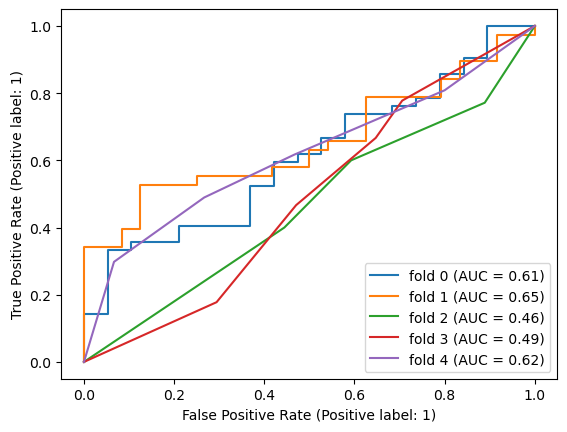

accuracy:0.6732416710735061, specificity: 0.010526315789473684, sensitivity:1.0, balanced_score: 0.5052631578947369


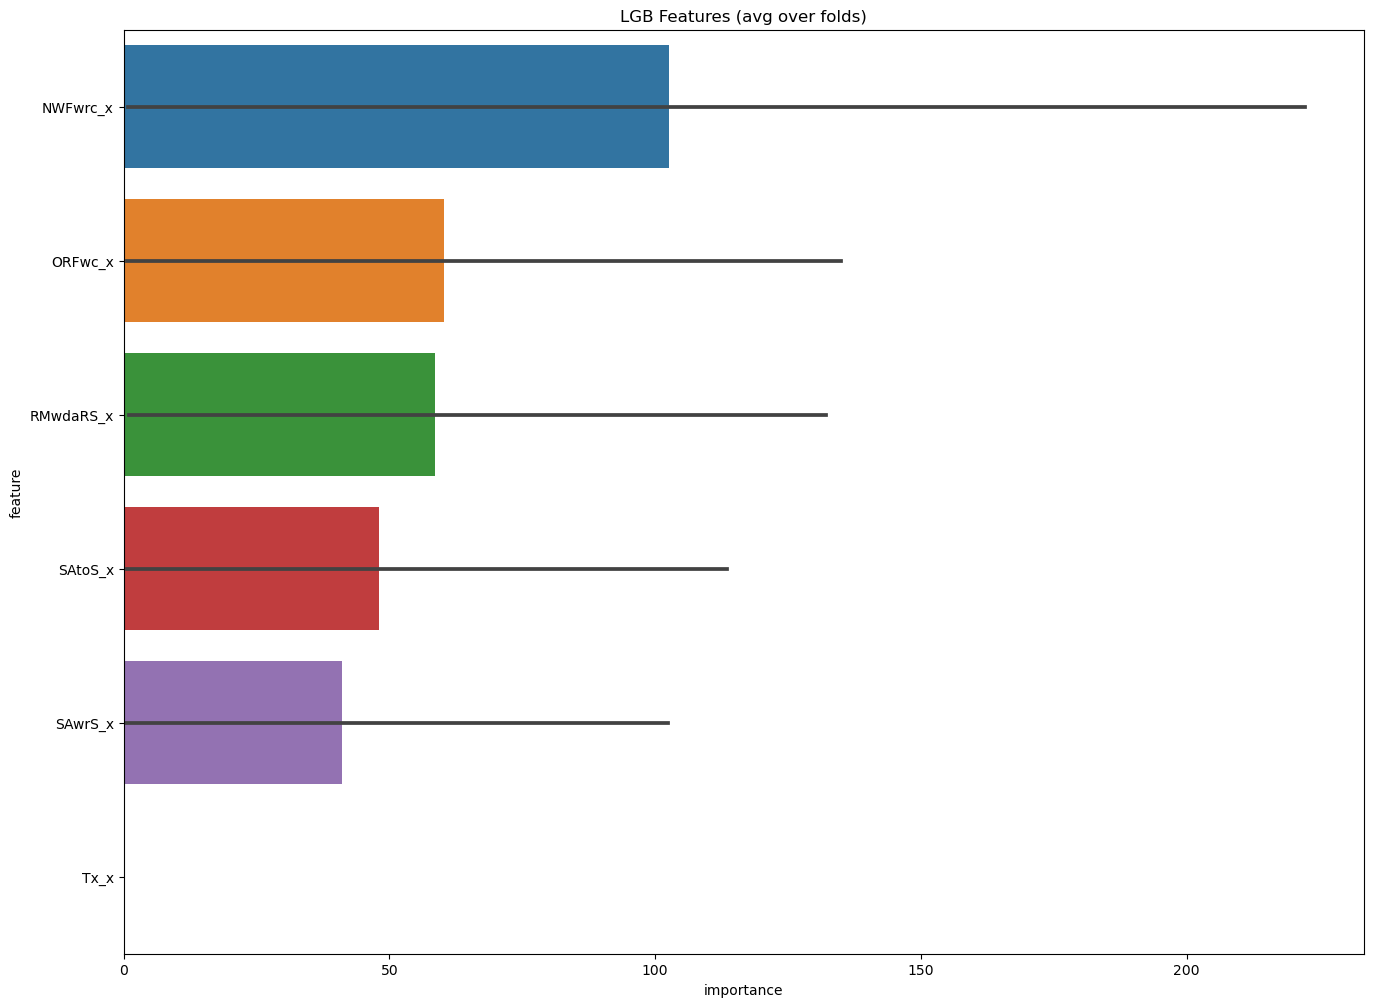

In [25]:
gkf = GroupKFold(n_splits = 5)

target = "RMwdaRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_intn[selected_features_wda], data_intn[target], groups=data_intn.SchlID_x)):
    X_train, y_train = data_intn[selected_features_wda].iloc[train_idx], data_intn[target].iloc[train_idx]
    X_valid, y_valid = data_intn[selected_features_wda].iloc[val_idx], data_intn[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = lgb.LGBMClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='binary_error',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = selected_features_wda
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');